<a href="https://www.kaggle.com/code/masatomurakawamm/tpu-gpu-cpu-deeplearning-eda-automl-pycaret?scriptVersionId=98509632" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
# [House Prices - Advanced Regression Techniques][1]

Goal: To predict the sales price for each house.

---
#### **The aim of this notebook is to**
- **1. Conduct Exploratory Data Analysis (EDA) and Feature Engineering.**
- **2. Use PyCaret for the entire ML pipeline.**
- **3. Create and train a Deep Learning model with TensorFlow.**
- **4. Learn how to use TPU.**

---
#### **Note:**
- You can run this notebook on CPU, GPU, and TPU without changing codes.
-  In this notebook, training model on TPU takes more time than on GPU or CPU, because of the small batch size, small datasets, ect. Please understand that I didn't optimize the experiment parameters for TPU.


---
#### **References:**
 Thanks to previous great codes and notebooks.

- [PyCaret Tutoricals][2]
 - [Regression Tutorial - Level Beginner][3]
 - [Regression Tutorial  - Level Intermediate][4]
 
- [How to Use Kaggle: Tensor Processing Units (TPUs)][6]

---
#### **My Previous Notebooks:**
- [SpaceshipTitanic: EDA + TabTransformer[TensorFlow]][5]

---
### **If you find this notebook useful, or when you copy&edit this notebook, please do give me an upvote. It helps me keep up my motivation.**

---
[1]: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
[2]: https://pycaret.gitbook.io/docs/get-started/tutorials
[3]: https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb
[4]: https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb
[5]: https://www.kaggle.com/code/masatomurakawamm/spaceshiptitanic-eda-tabtransformer-tensorflow
[6]: https://www.kaggle.com/docs/tpu

<h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>0. TABLE OF CONTENTS</center></h1>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#1" class="list-group-item list-group-item-action">1. Settings</a></li>
    <li><a href="#2" class="list-group-item list-group-item-action">2. Data Loading</a></li>
    <li><a href="#3" class="list-group-item list-group-item-action">3. EDA and Feature Engineering</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#3.1" class="list-group-item list-group-item-action">3.1 AutoEDA with Sweetviz</a></li>
            <li><a href="#3.2" class="list-group-item list-group-item-action">3.2 Feature Selection</a></li>
            <li><a href="#3.3" class="list-group-item list-group-item-action">3.3 Target Distribution</a></li>
            <li><a href="#3.4" class="list-group-item list-group-item-action">3.4 Numerical Features</a></li>
            <li><a href="#3.5" class="list-group-item list-group-item-action">3.5 Categorical Features</a></li>
            <li><a href="#3.6" class="list-group-item list-group-item-action">3.6 Validation Split</a></li>
        </ul>
    </li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. PyCaret</a></li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Deep Learning</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#5.1" class="list-group-item list-group-item-action">5.1 Creating Dataset</a></li>
            <li><a href="#5.2" class="list-group-item list-group-item-action">5.2 Creating Model</a></li>
            <li><a href="#5.3" class="list-group-item list-group-item-action">5.3 Training Model</a></li>
            <li><a href="#5.4" class="list-group-item list-group-item-action">5.4 Inference</a></li>
        </ul>
    </li>
</ul>

<a id ="1"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>1. Settings</center></h1>

In [1]:
## Parameters
data_config = {'train_csv_path': '../input/house-prices-advanced-regression-techniques/train.csv',
               'test_csv_path': '../input/house-prices-advanced-regression-techniques/test.csv',
               'sample_submission_path': '../input/house-prices-advanced-regression-techniques/sample_submission.csv',
              }

exp_config = {'gpu': False,
              'competition_name': 'house-prices-advanced-regression-techniques',
              'n_splits': 5,
              'normalization': 'Robust',
              'encoding': 'one_hot',
              'n_sample_per_TPU_core': 16,
              'batch_size': 128,
              'learning_rate': 1e-3,
              'train_epochs': 100,
              'checkpoint_filepath': './tmp/model/exp.ckpt',
             }

model_config = {'model_units': [256, 256],
                'dropout_rates': [0., 0.2,],
               }

print('Parameters setted!')

Parameters setted!


In [2]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import pathlib
import gc
import sys
import re
import math 
import random
import time 
import datetime as dt
from tqdm import tqdm 

print('Import done!')

Import done!


In [3]:
## For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    os.environ['PYTHONHASHSEED'] = str(s) 
    print('Seeds setted!')
    
global_seed = 42
seed_all(global_seed)

Seeds setted!


---
# [TPU] Distribution Strategy #

A TPU has eight different *cores* and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a **distribution strategy**. Run the following cell to create the distribution strategy that we'll later apply to our model. We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different replicas of the model, one for each core.

In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


---

<a id ="2"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>2. Data Loading</center></h1>

---
### [File and Data Field Descriptions](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

- **train.csv** - the training set
- **test.csv** - the test set
- **data_description.txt** - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- **sample_submission.csv** - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms.


---
### [Submission & Evaluation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)

- Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

---

In [5]:
## Data Loading
train_df = pd.read_csv(data_config['train_csv_path'])
test_df = pd.read_csv(data_config['test_csv_path'])
submission_df = pd.read_csv(data_config['sample_submission_path'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 1460
test_lenght: 1459
submission_length: 1459


In [6]:
## Null Value Check
print('train_df.info()'); print(train_df.info(), '\n')
print('test_df.info()'); print(test_df.info(), '\n')

## train_df Check
train_df.head()

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

---
## [TPU] Loading the Competition Data ##

When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/). You can use data from any public GCS bucket by giving its path just like you would data from `'/kaggle/input'`. The following will retrieve the GCS path for this competition's dataset.

In [7]:
competition_name = exp_config['competition_name'] ## Change the competition name

## Get GCS Path
from kaggle_datasets import KaggleDatasets

if tpu:
    DATA_DIR = KaggleDatasets().get_gcs_path(competition_name) 
    print(DATA_DIR) ## What do gcs paths look like
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
else:
    DATA_DIR = '/kaggle/input/' + competition_name
    save_locally = None
    load_locally = None

print(f"\n... Data Directory Path:\n\t--> {DATA_DIR}")
print("\n... Contents of Data Directory:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")


... Data Directory Path:
	--> /kaggle/input/house-prices-advanced-regression-techniques

... Contents of Data Directory:
	--> /kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
	--> /kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
	--> /kaggle/input/house-prices-advanced-regression-techniques/train.csv
	--> /kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [8]:
## Data Loading
if tpu:
    train_csv_path = os.path.join(DATA_DIR, "train.csv")
    test_csv_path = os.path.join(DATA_DIR, "test.csv")
    sample_submission_path = os.path.join(DATA_DIR, 'sample_submission.csv')
    
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)
    submission_df = pd.read_csv(sample_submission_path)
    
else:
    train_df = pd.read_csv(data_config['train_csv_path'])
    test_df = pd.read_csv(data_config['test_csv_path'])
    submission_df = pd.read_csv(data_config['sample_submission_path'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 1460
test_lenght: 1459
submission_length: 1459


After Loading data, we can conduct EDA or Feature Engineering just as like on CPU/GPU.

---

<a id ="3"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>3. EDA and Feature Engineering</center></h1>

<a id ="3.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.1 AutoEDA with Sweetviz</center></h2>

In [9]:
## Import dependencies
!pip install -U -q sweetviz 
import sweetviz

                                             |          | [  0%]   00:00 -> (? left)


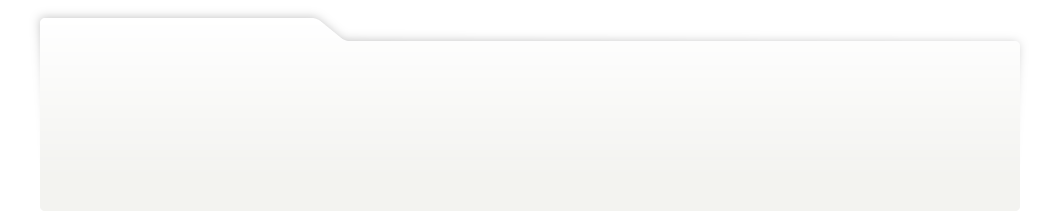
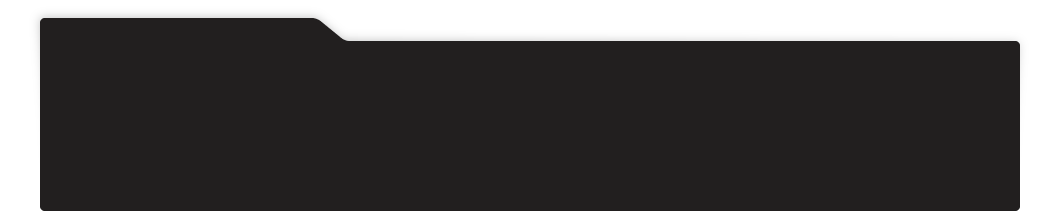
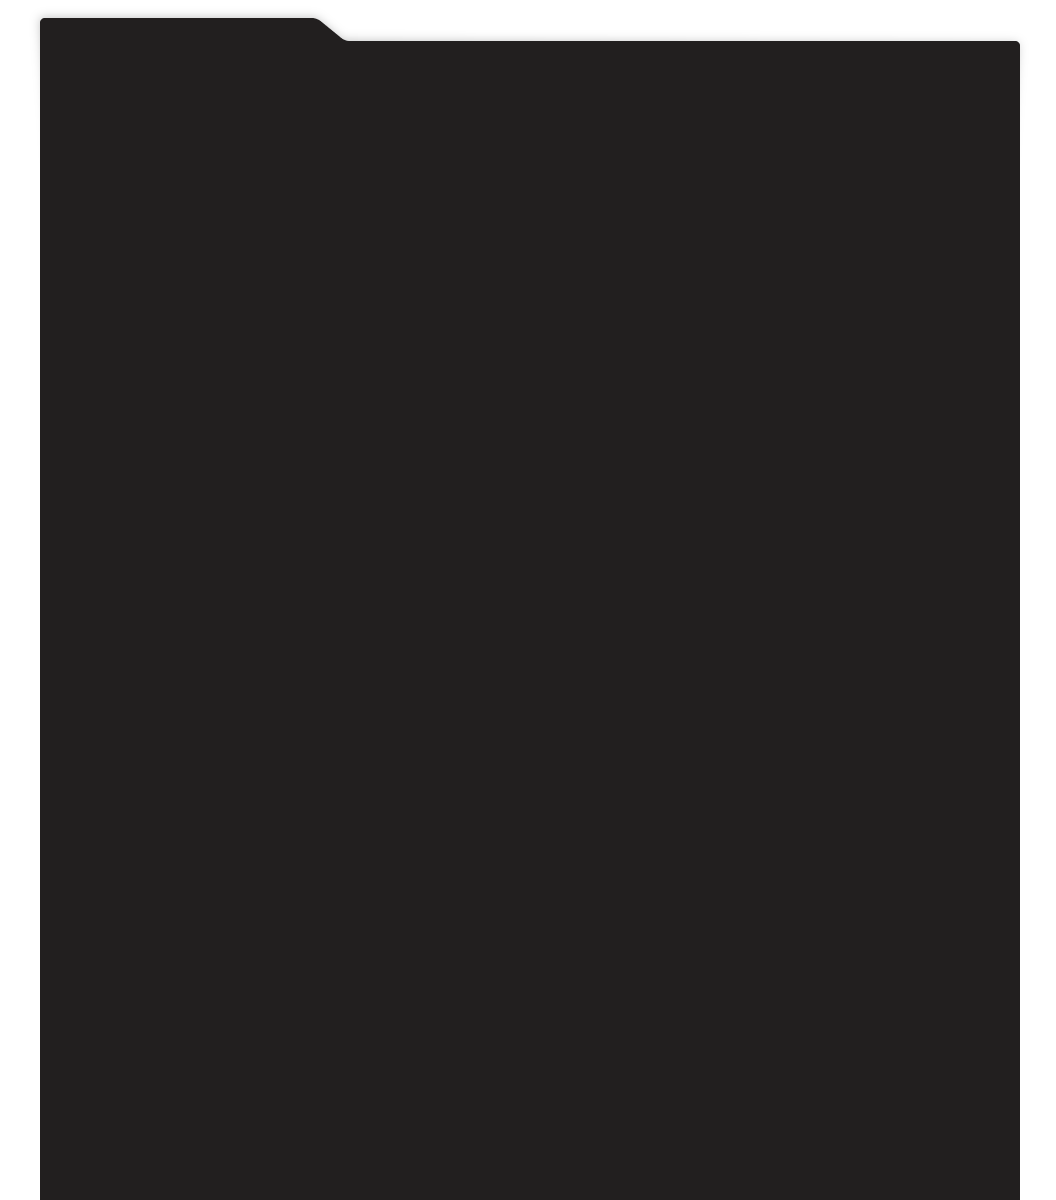
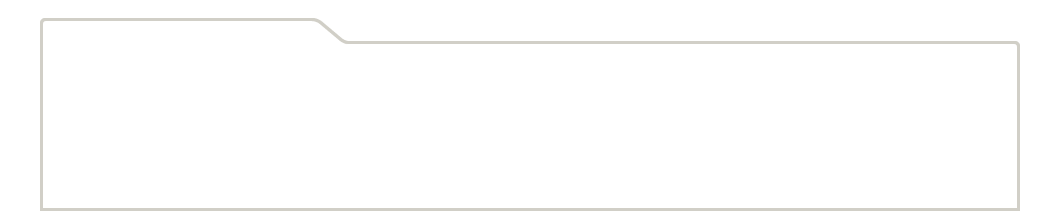
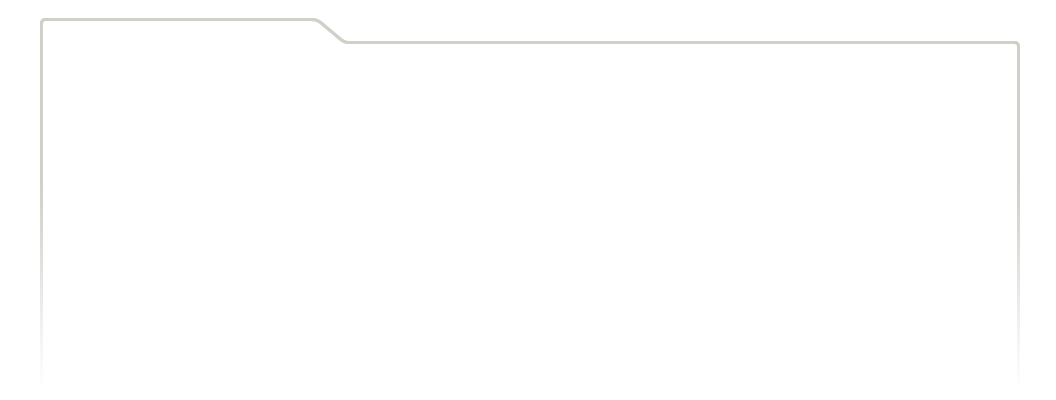
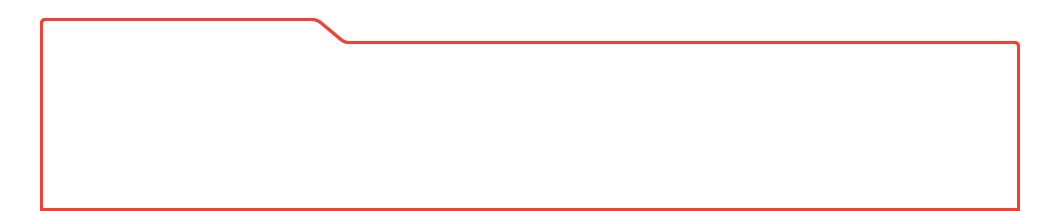
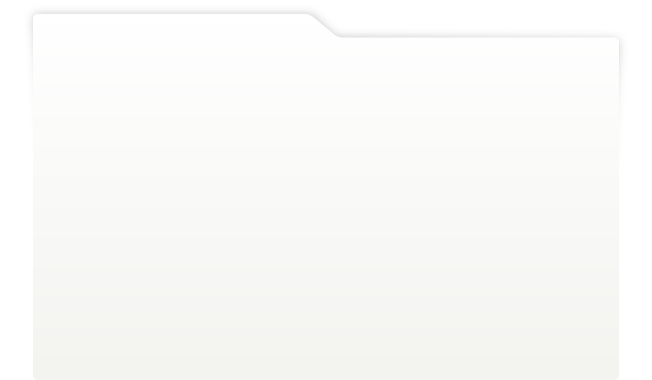
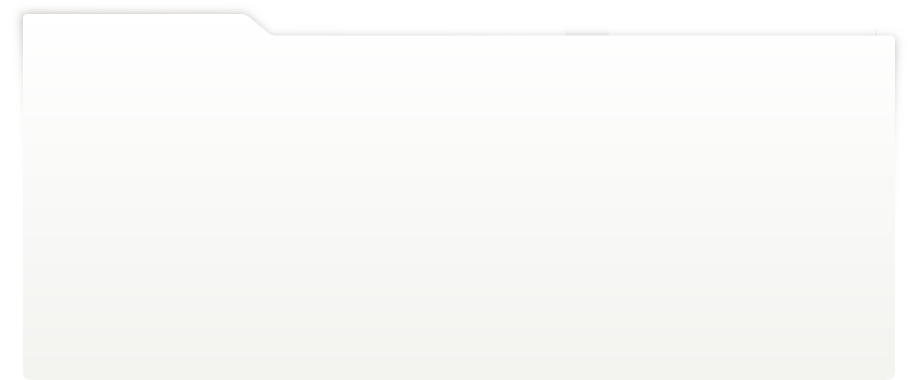
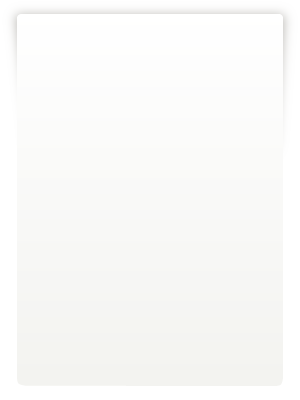
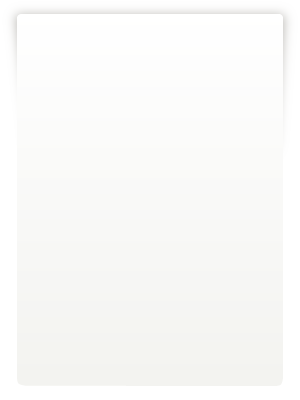
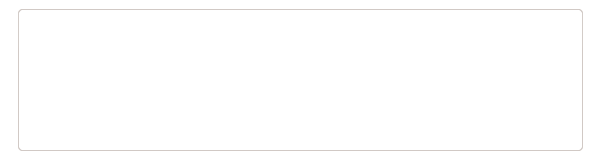
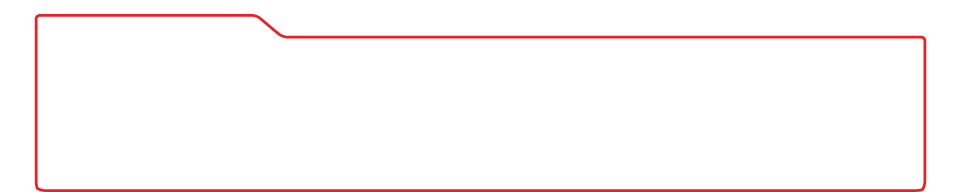
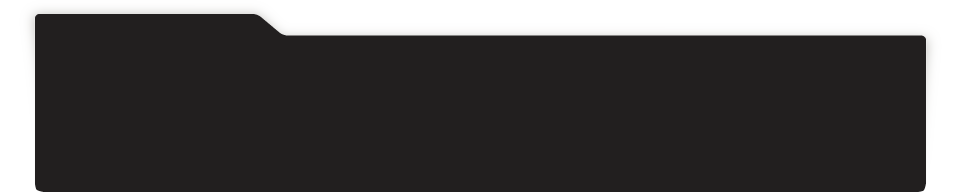
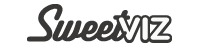
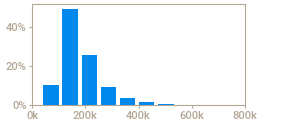
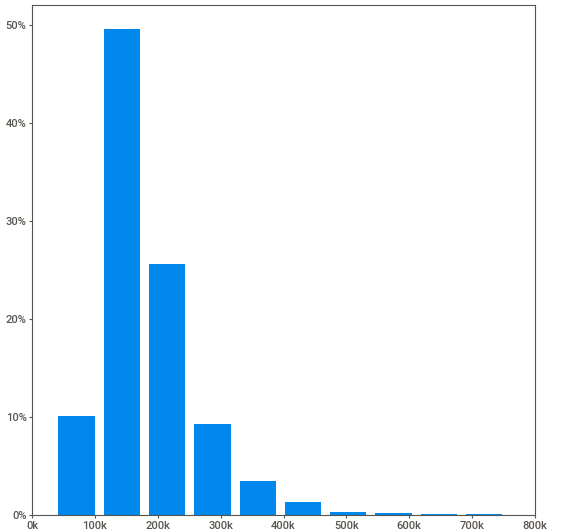
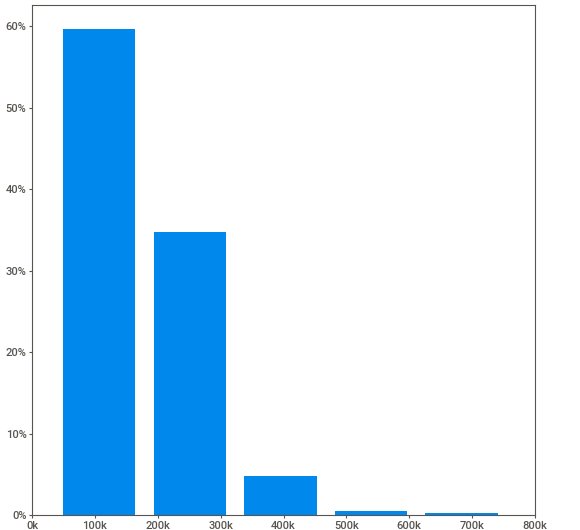
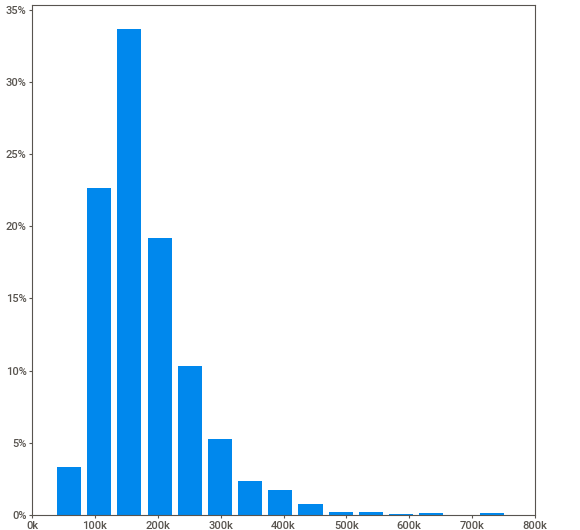
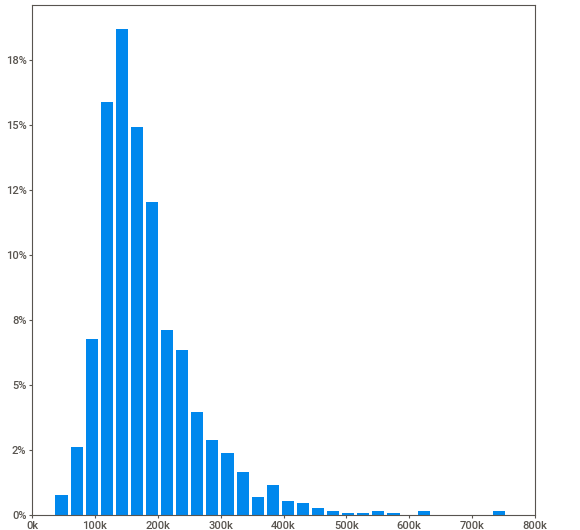
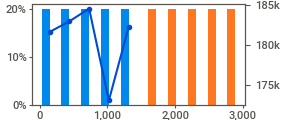
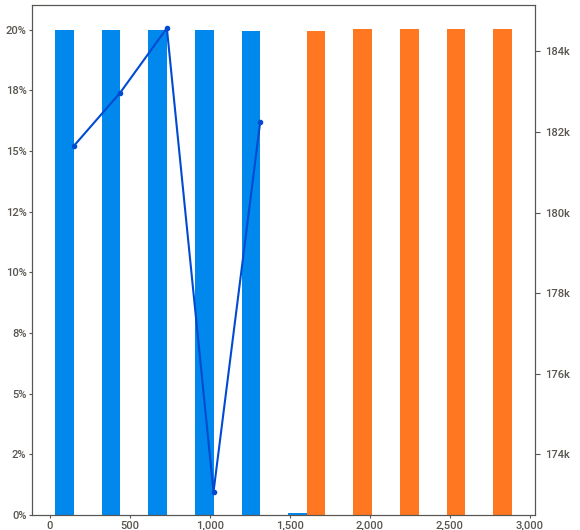
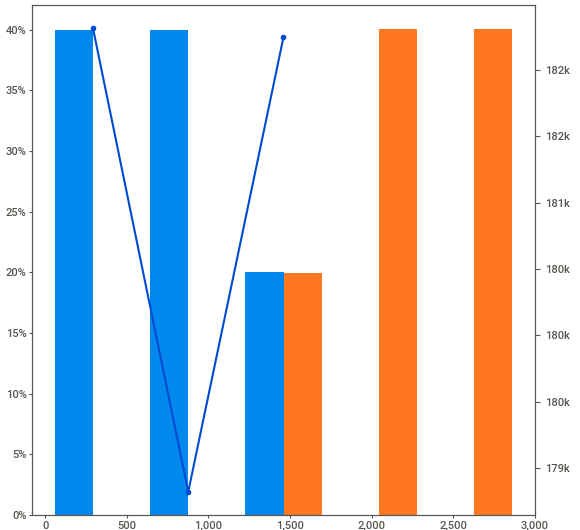
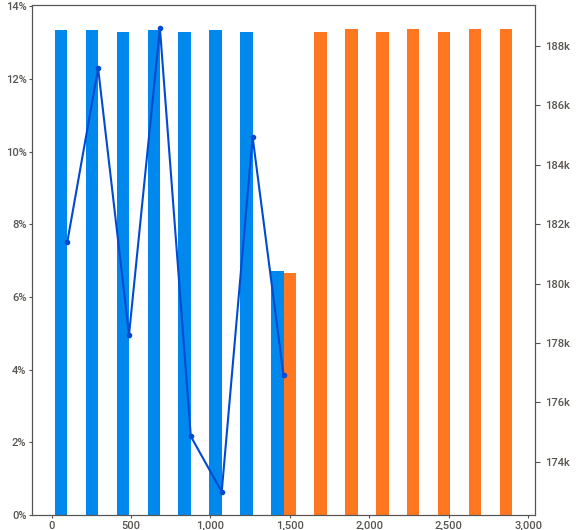
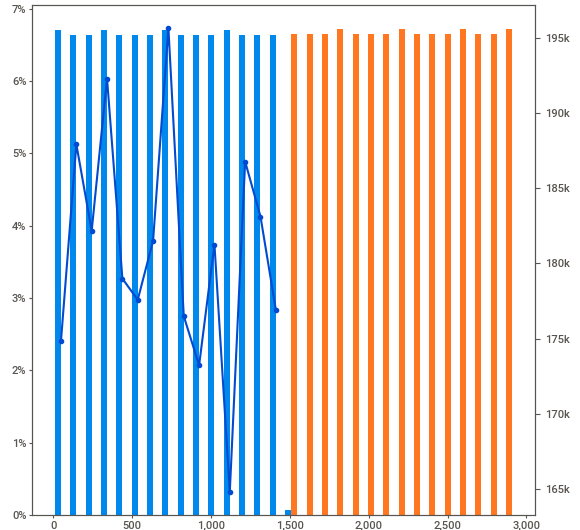
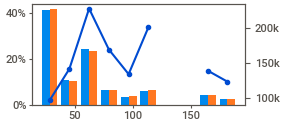
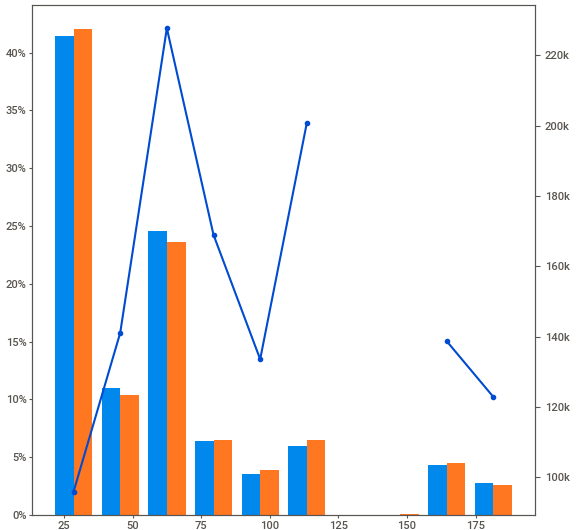
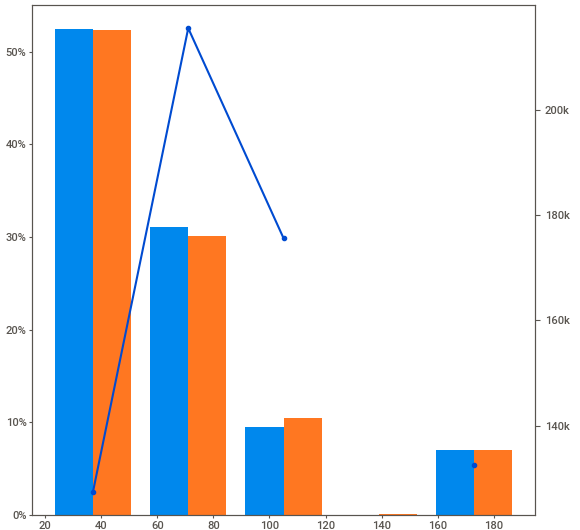
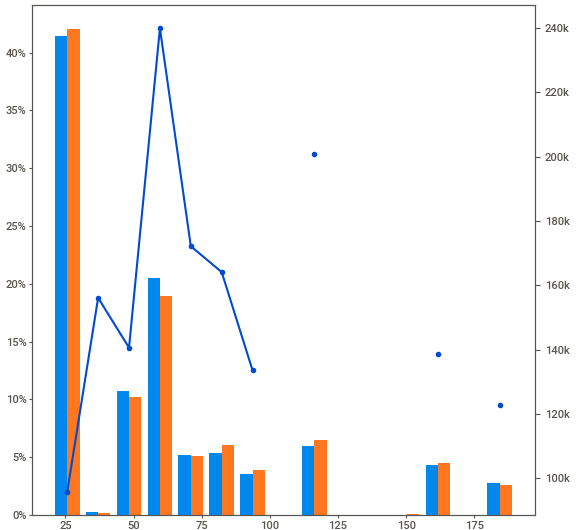
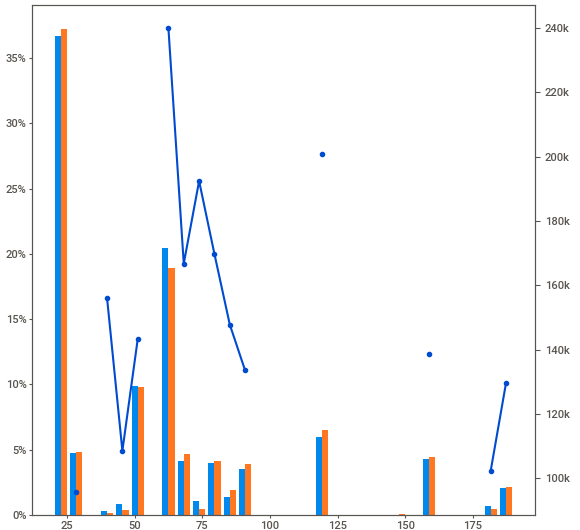
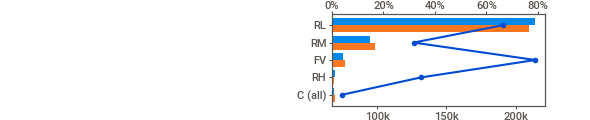
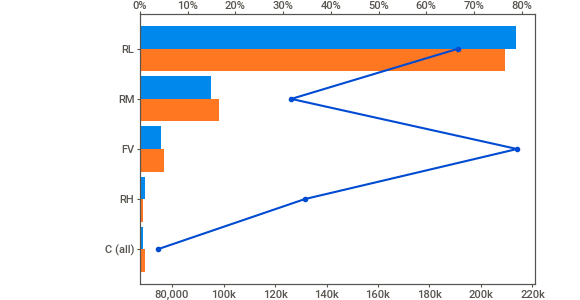
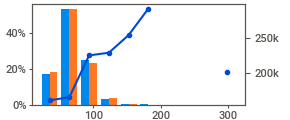
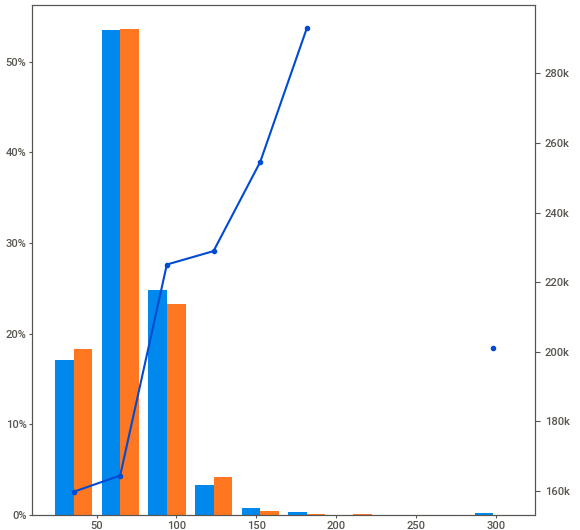
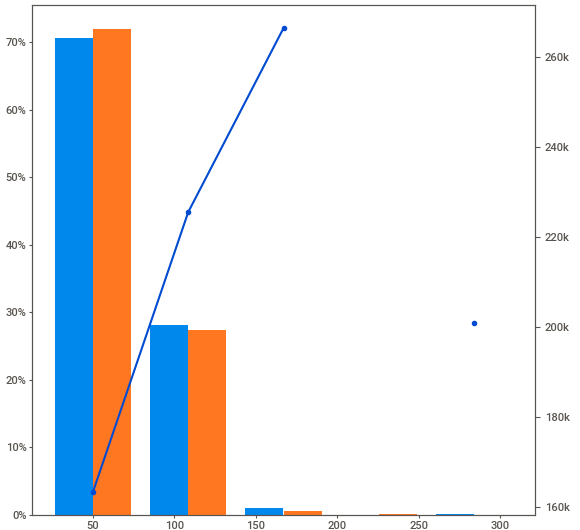
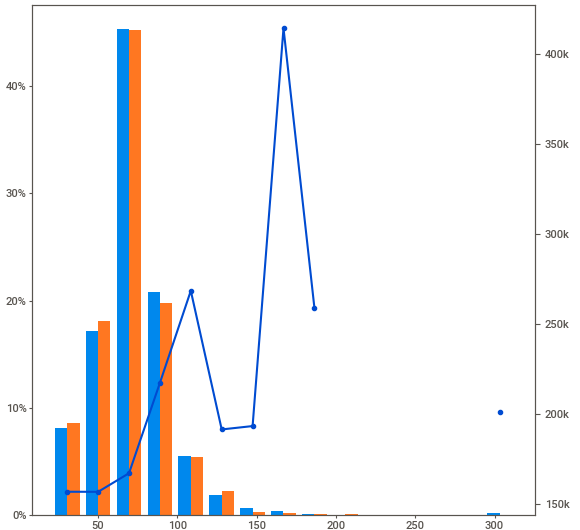
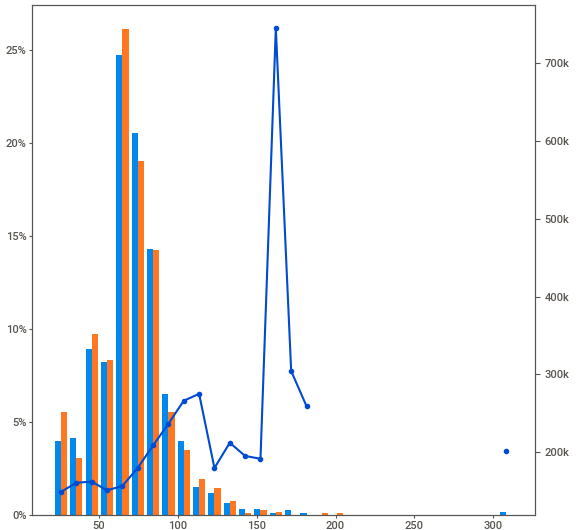
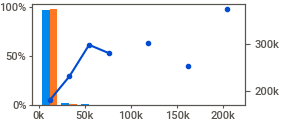
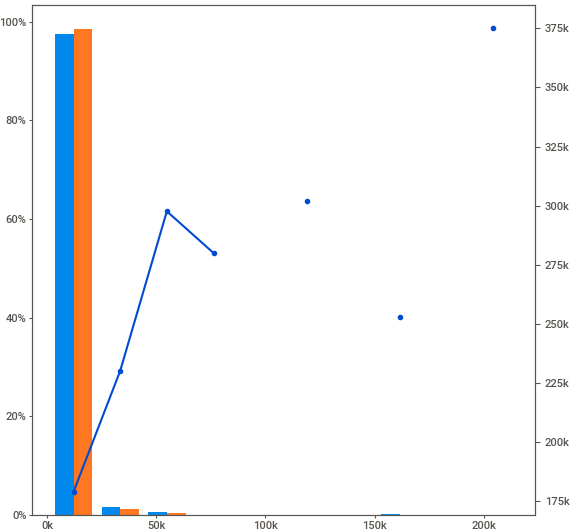
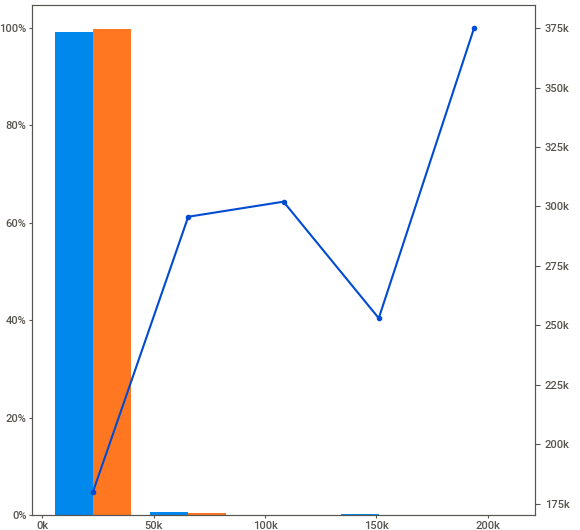
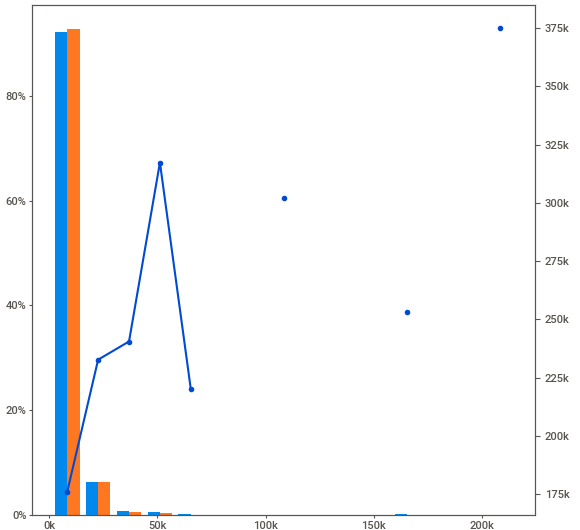
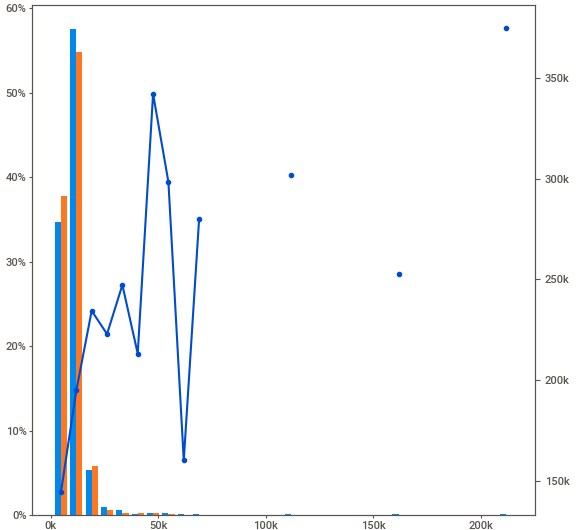
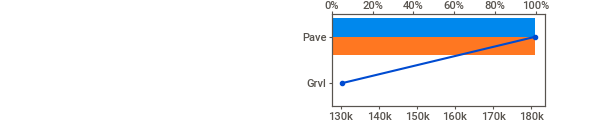
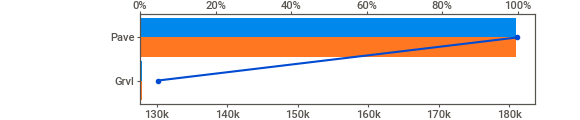
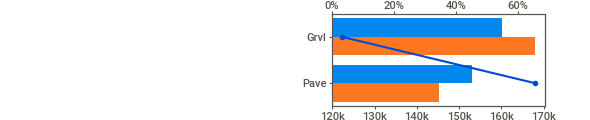
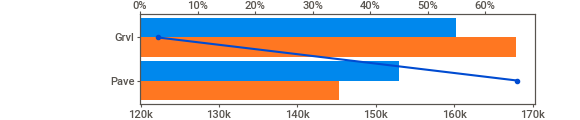
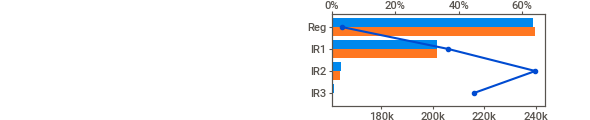
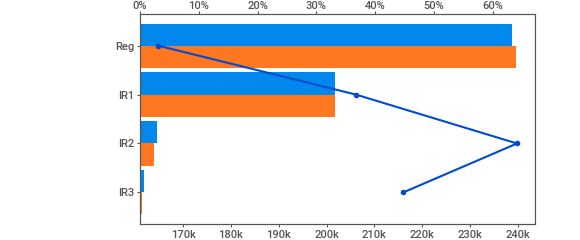
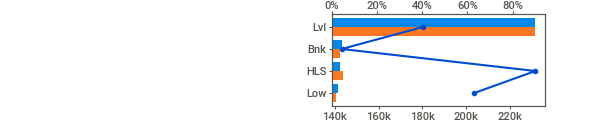
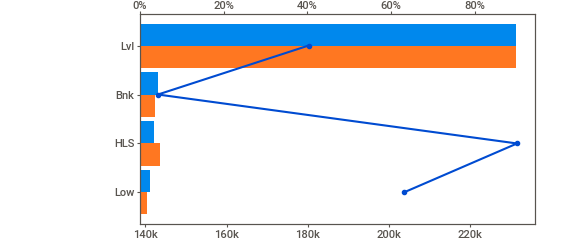
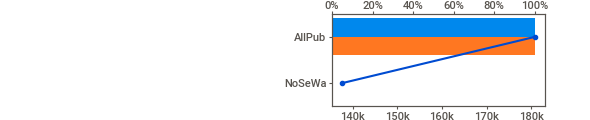
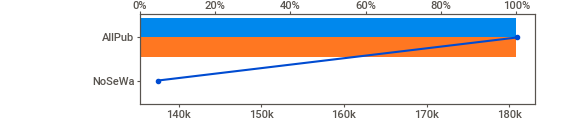
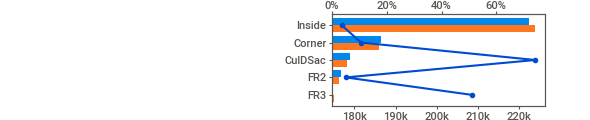
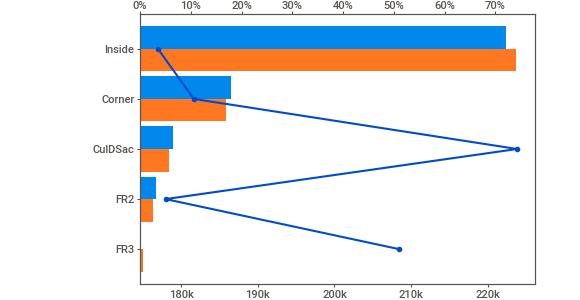
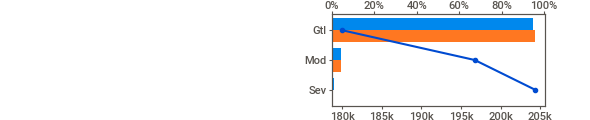
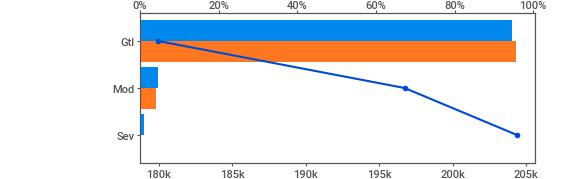
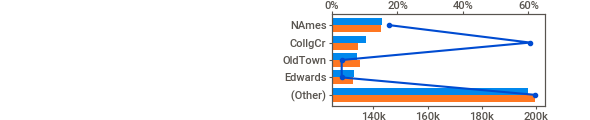
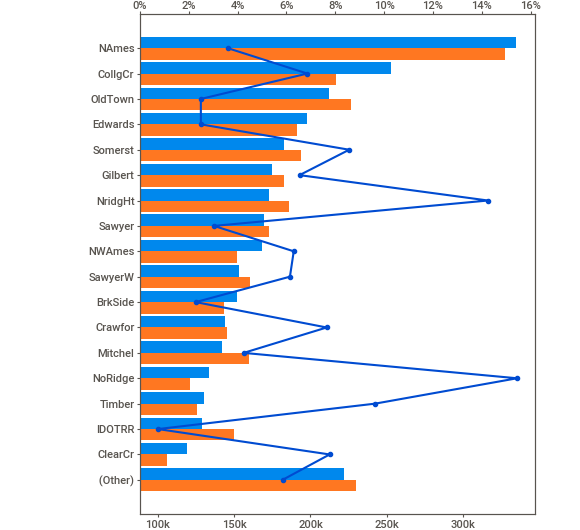
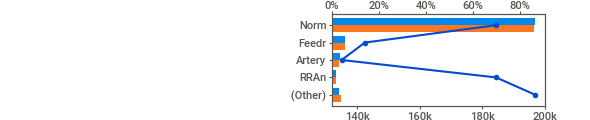
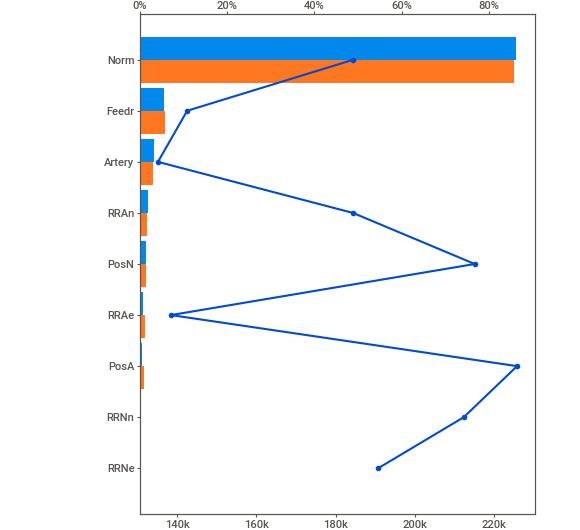
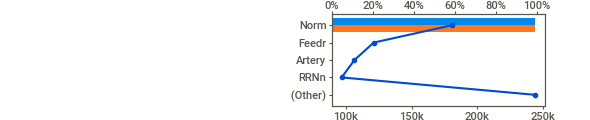
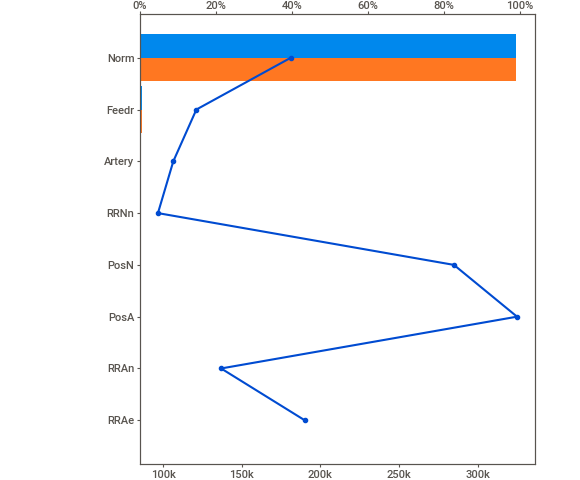
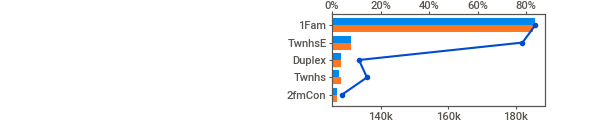
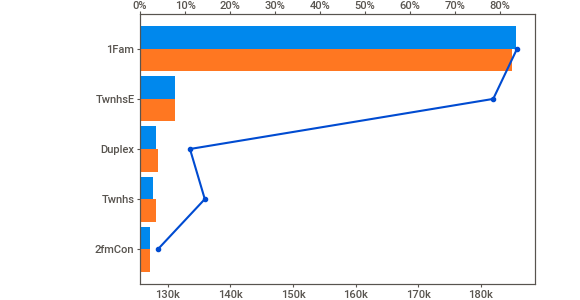
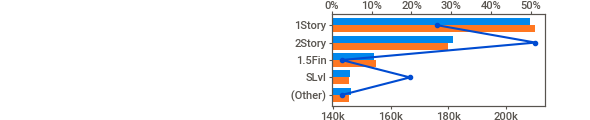
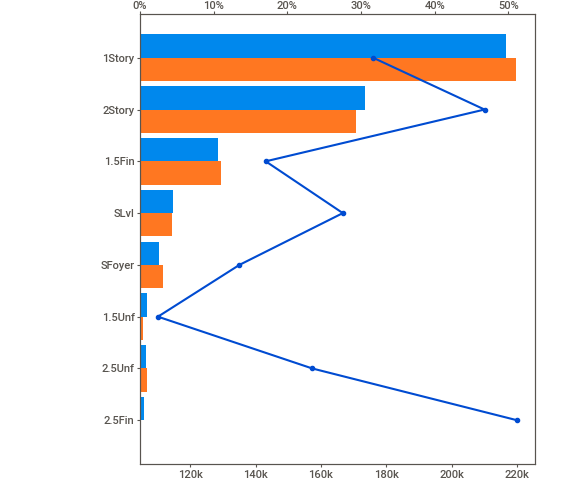
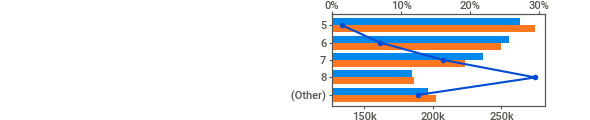
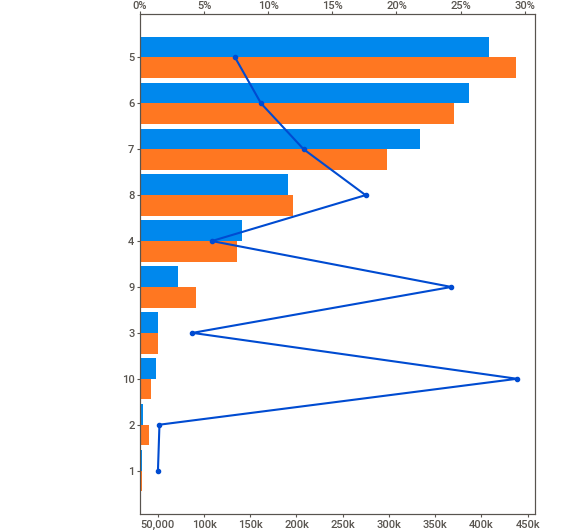
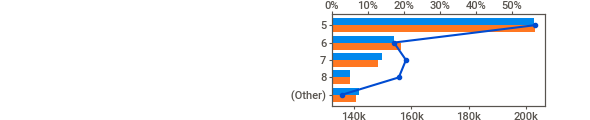
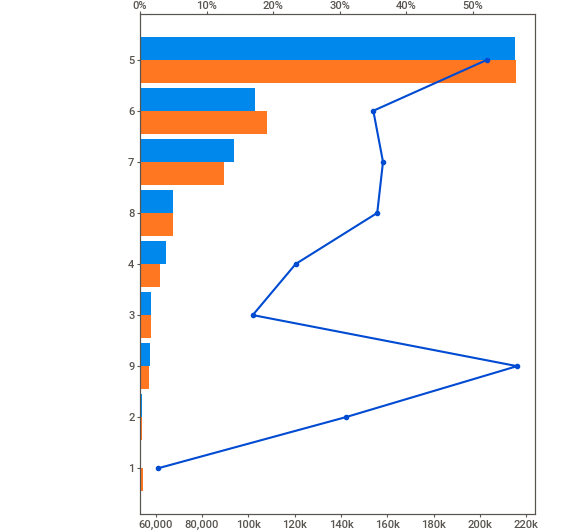
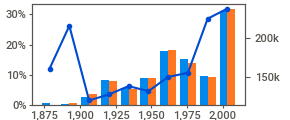
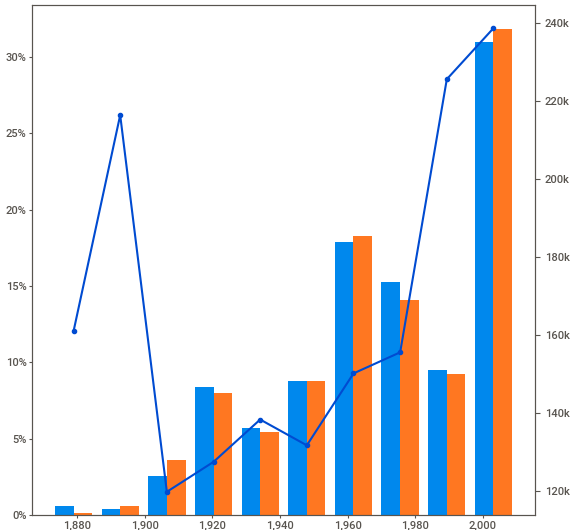
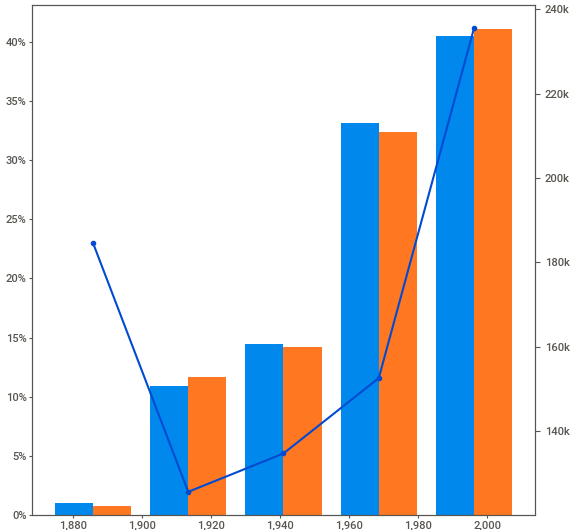
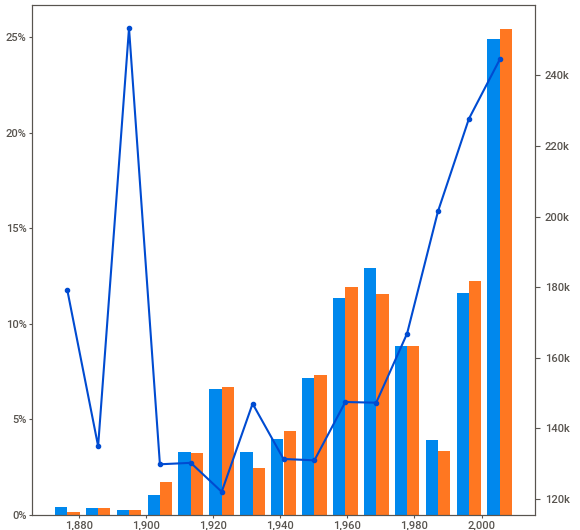
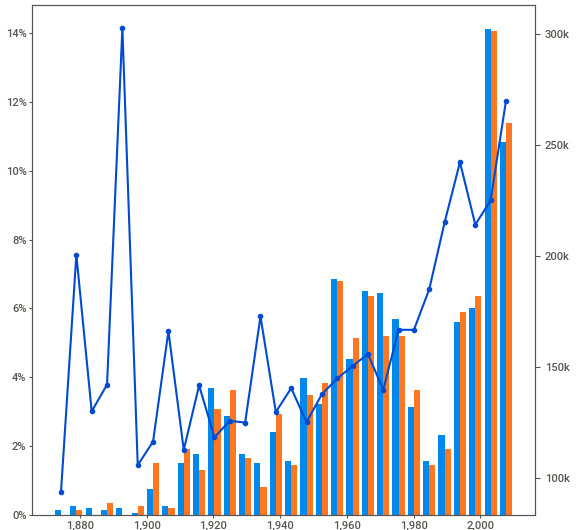
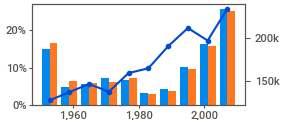
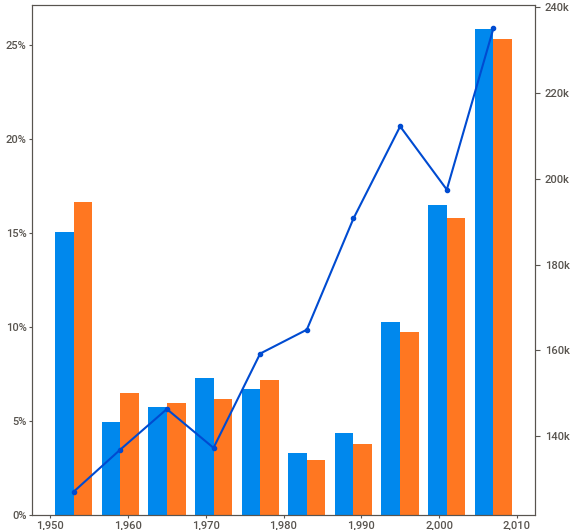
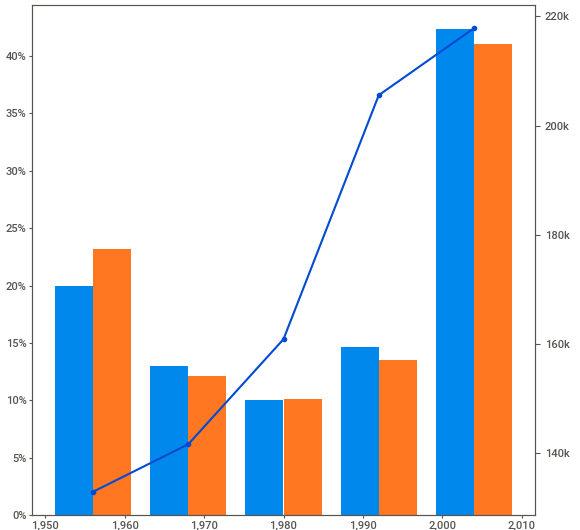
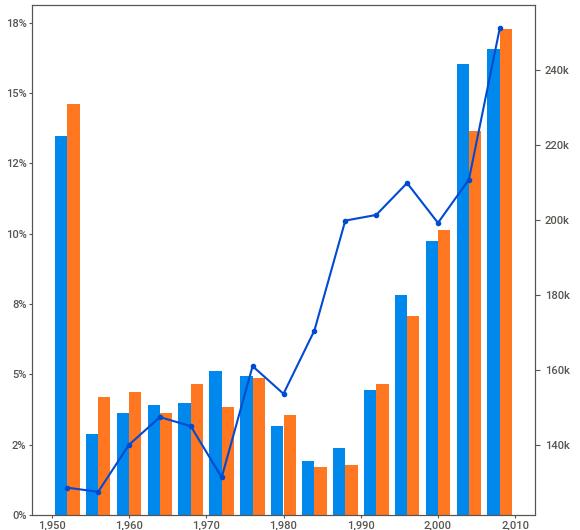
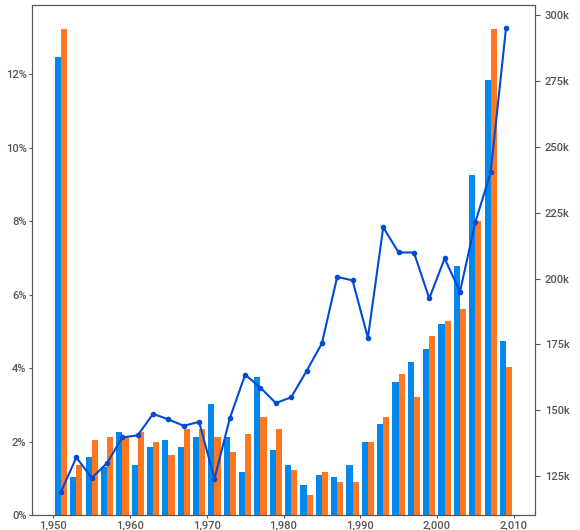
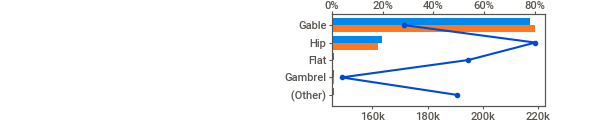
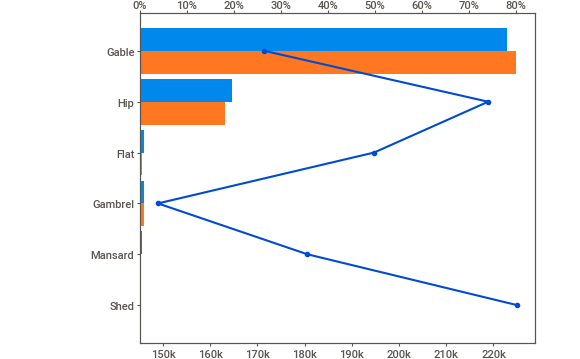
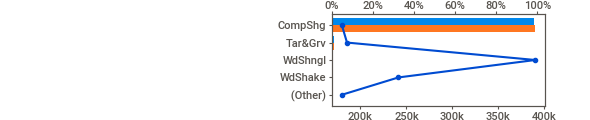
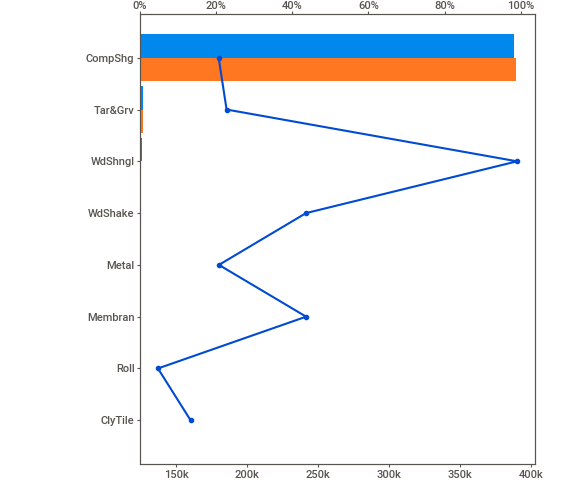
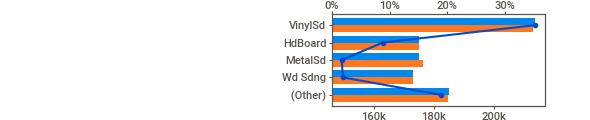
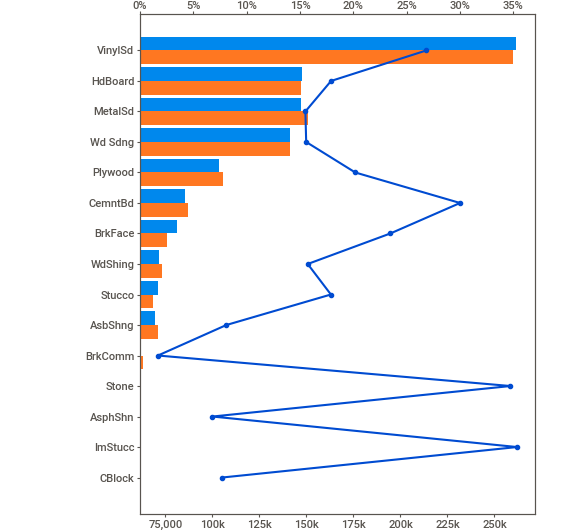
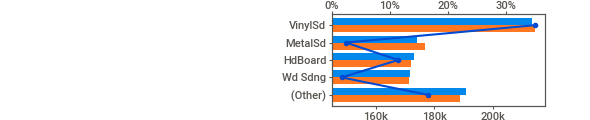
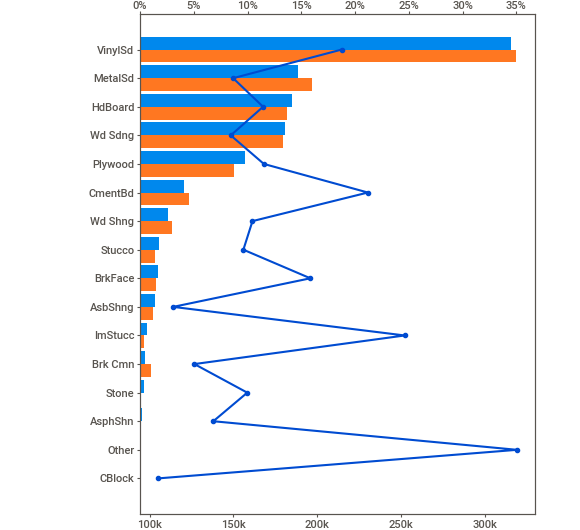
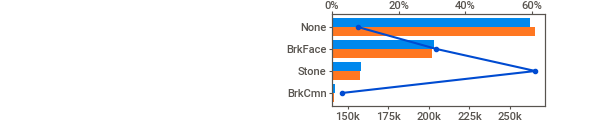
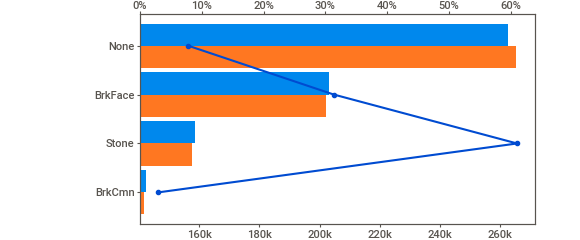
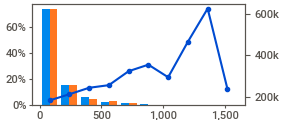
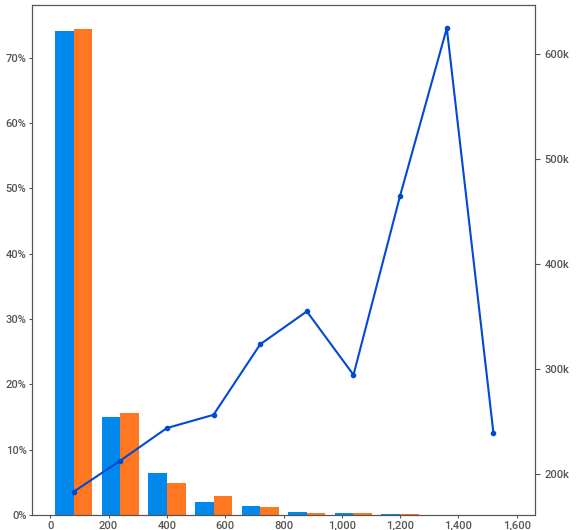
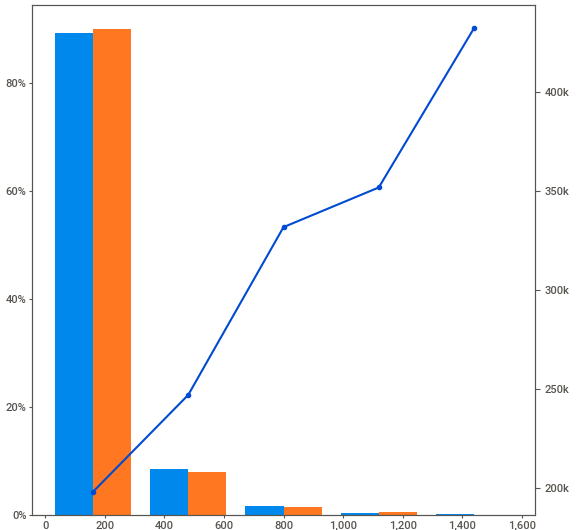
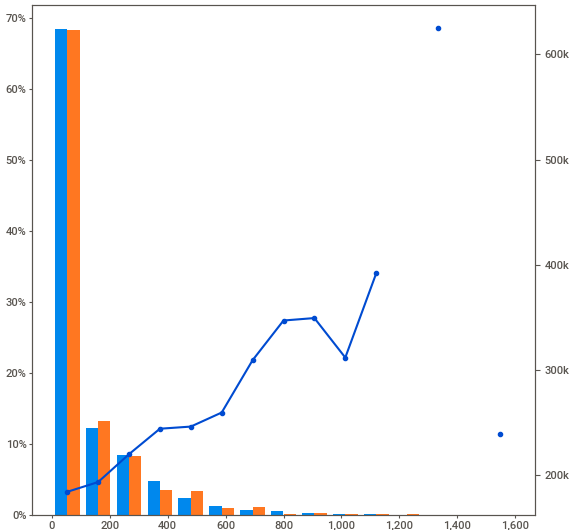
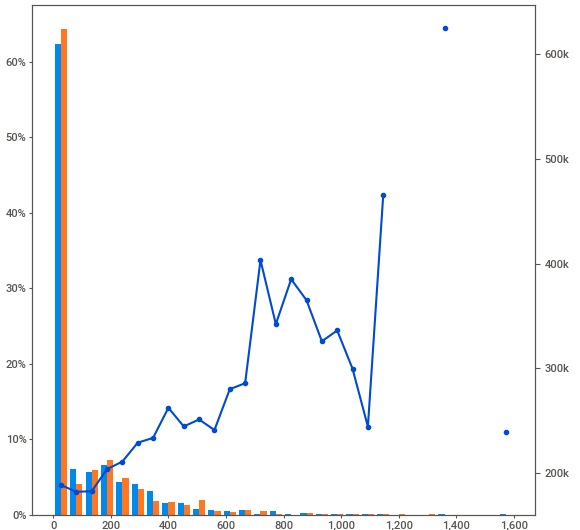
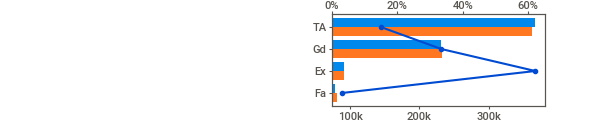
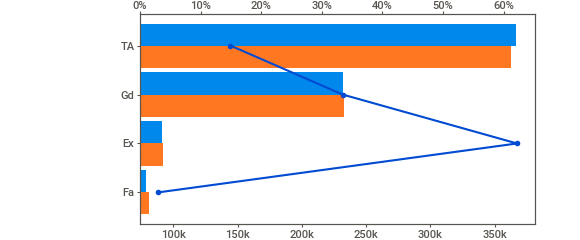
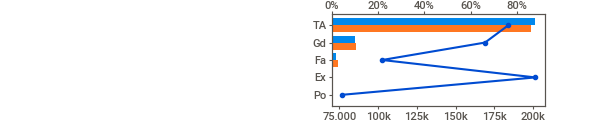
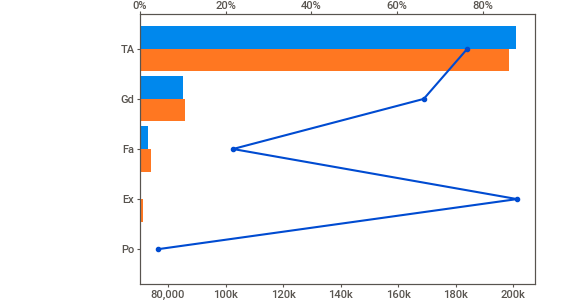
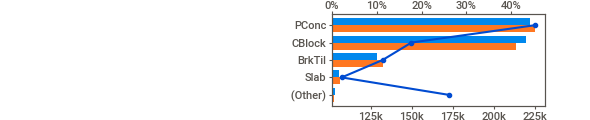
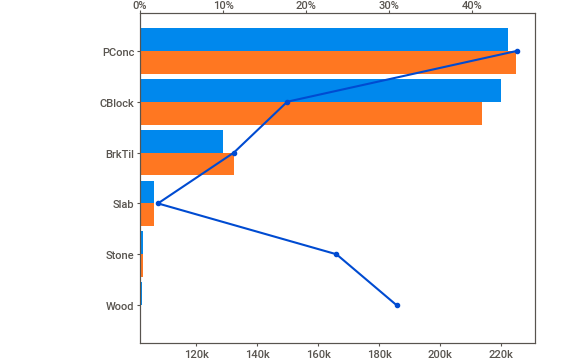
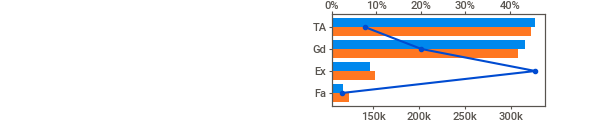
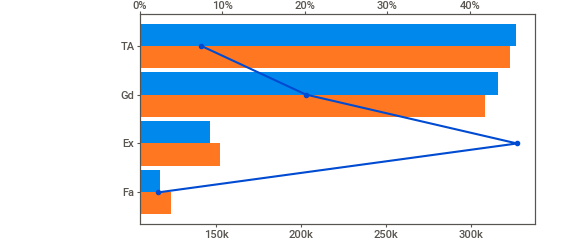
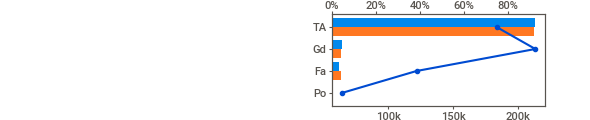
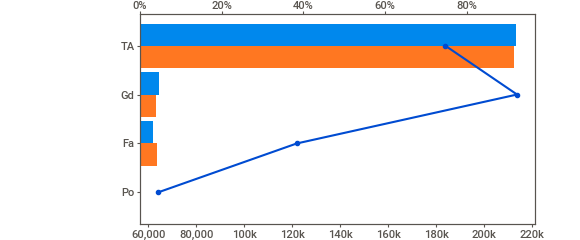
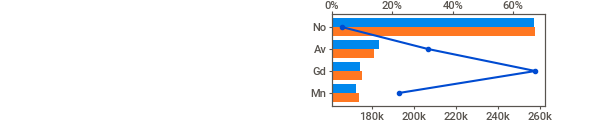
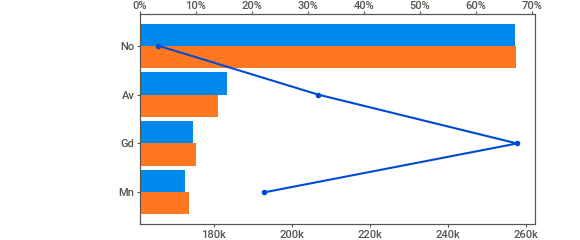
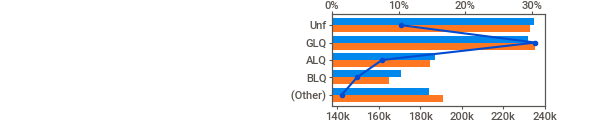
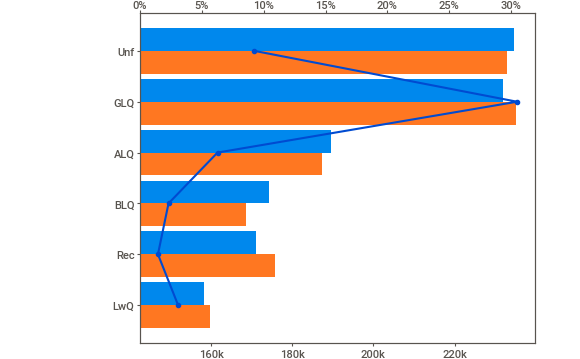
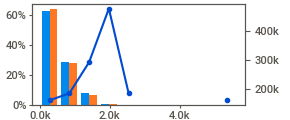
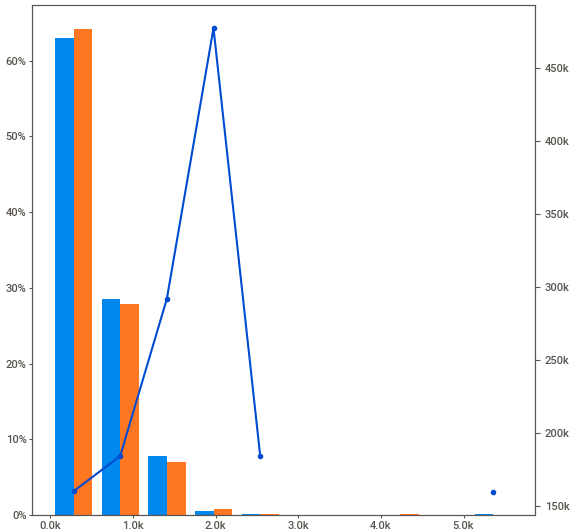
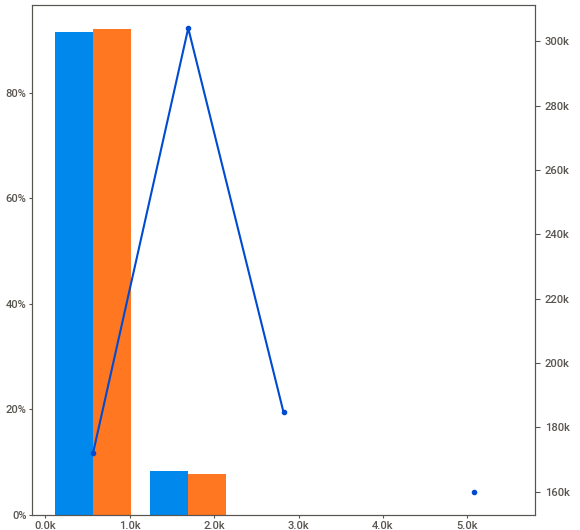
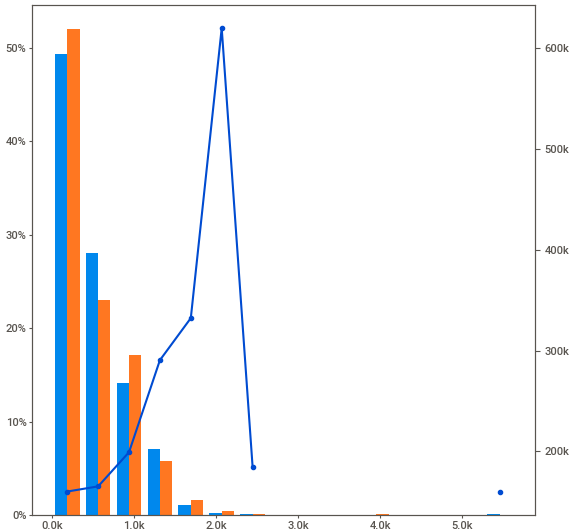
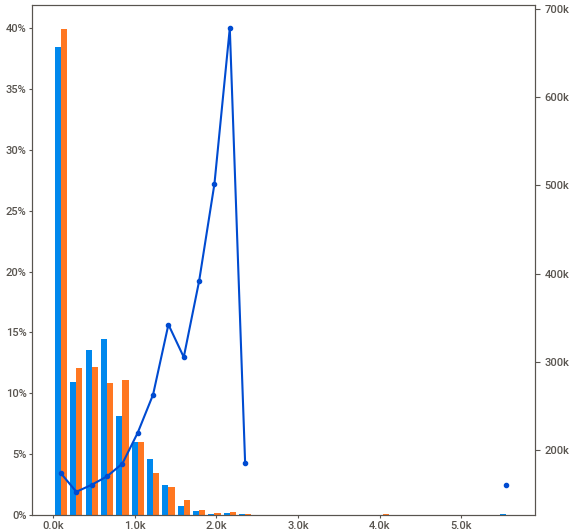
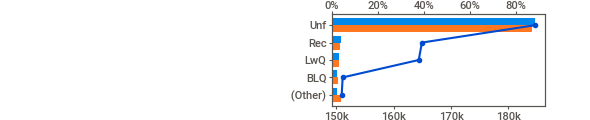
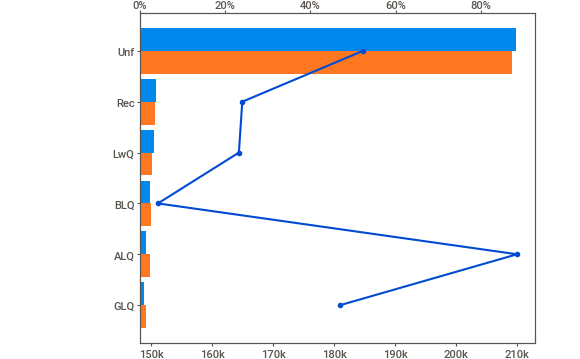
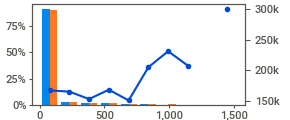
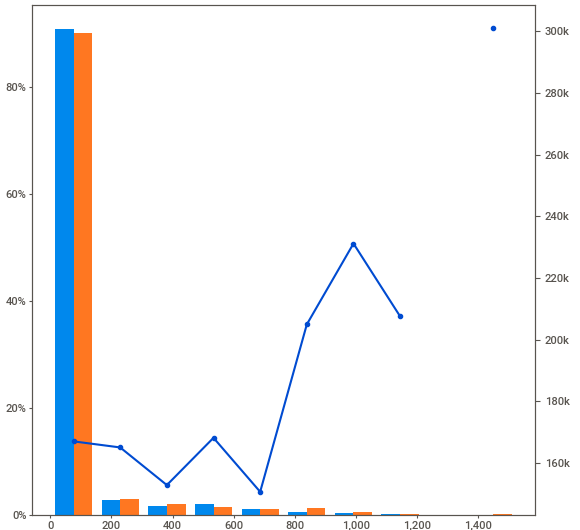
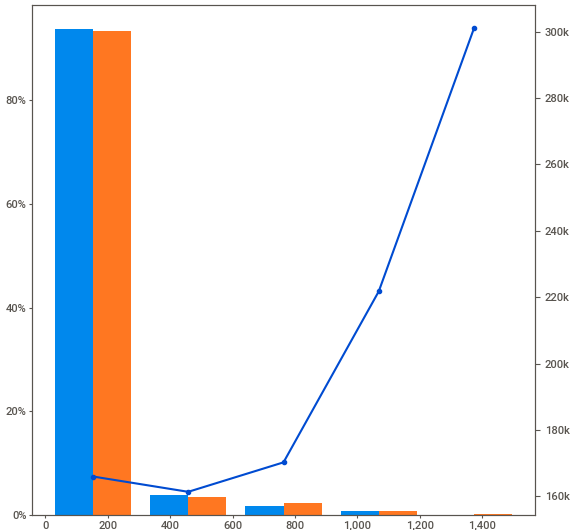
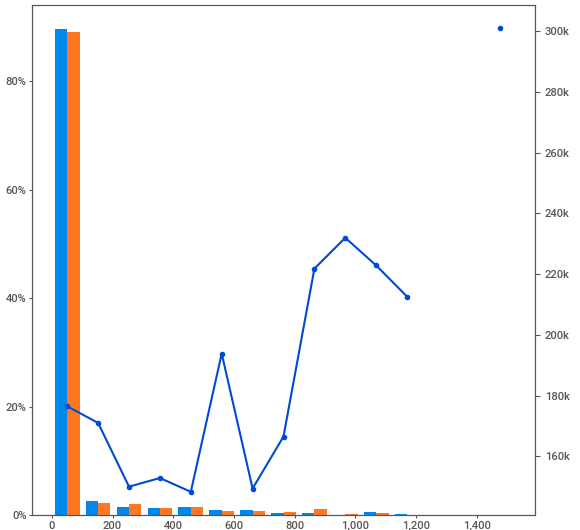
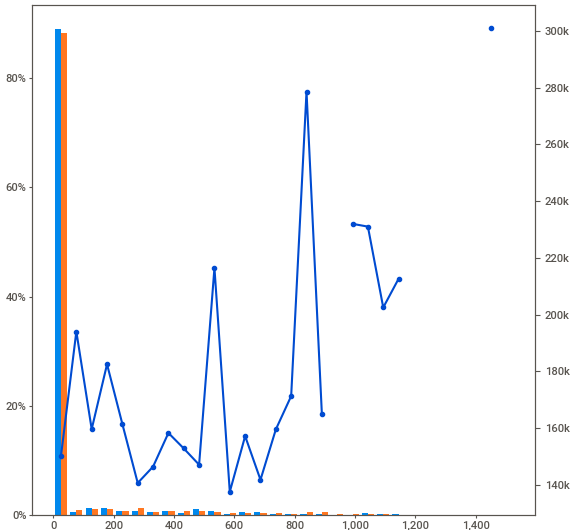
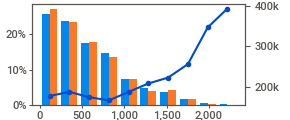
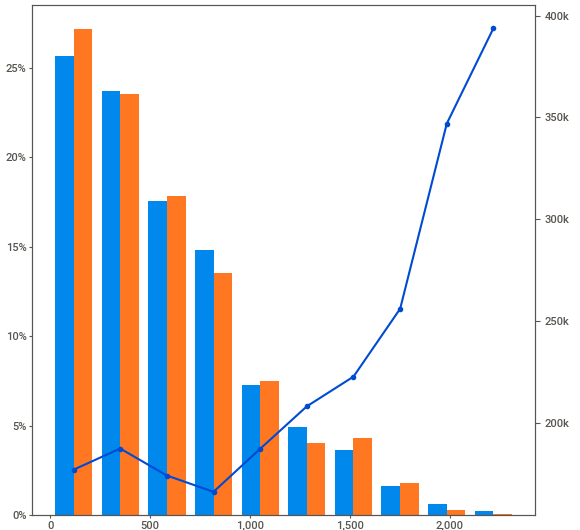
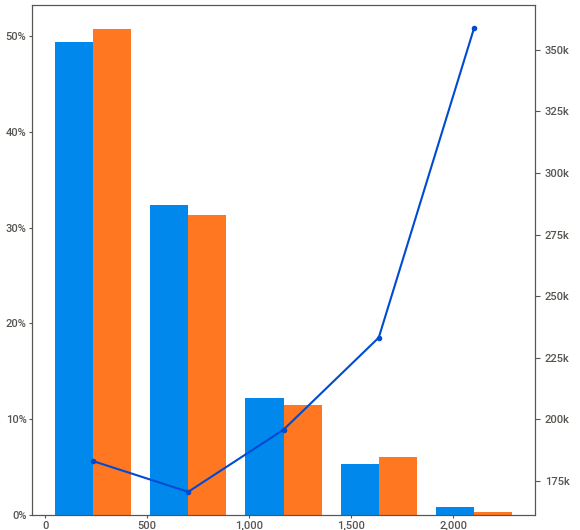
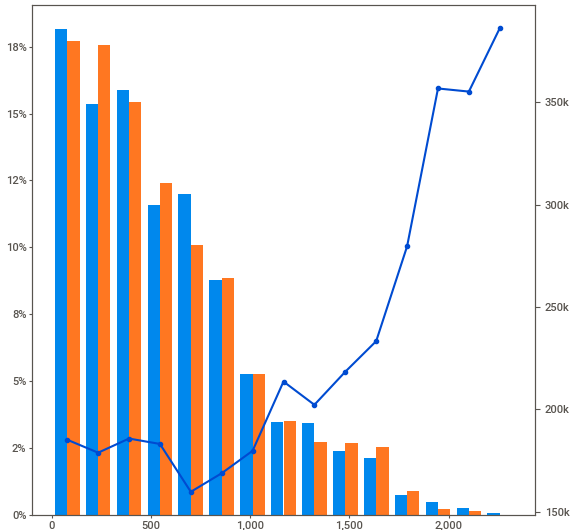
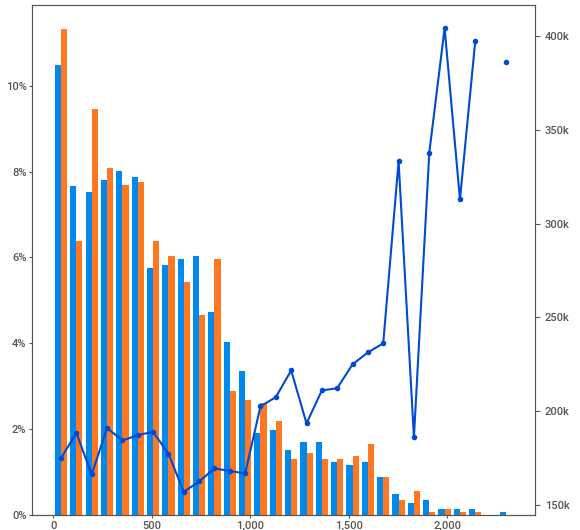
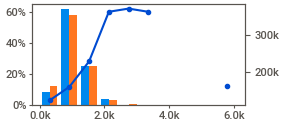
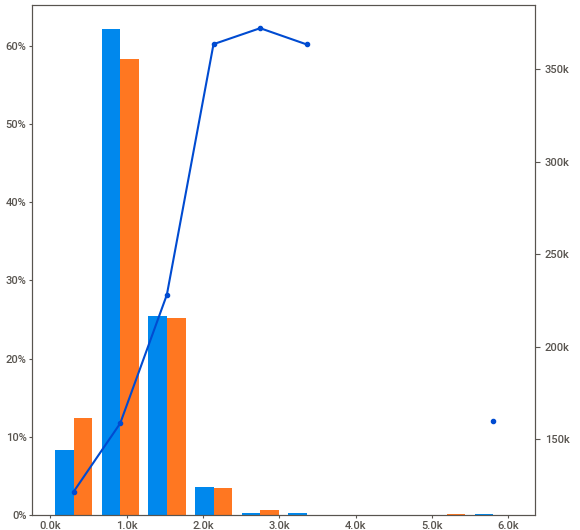
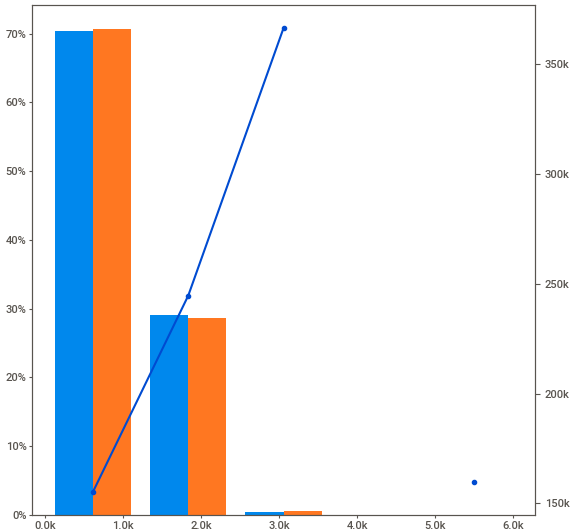
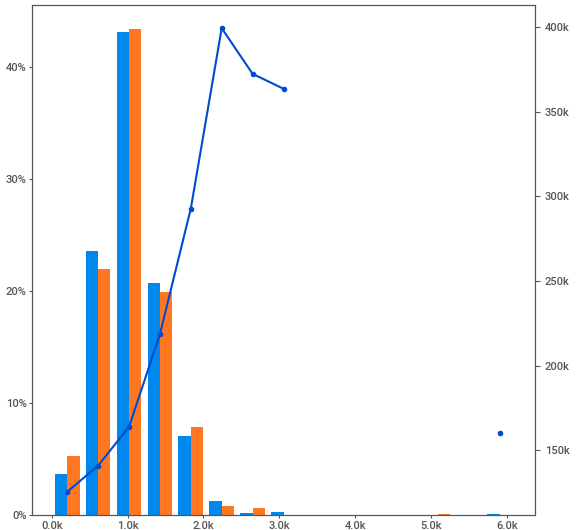
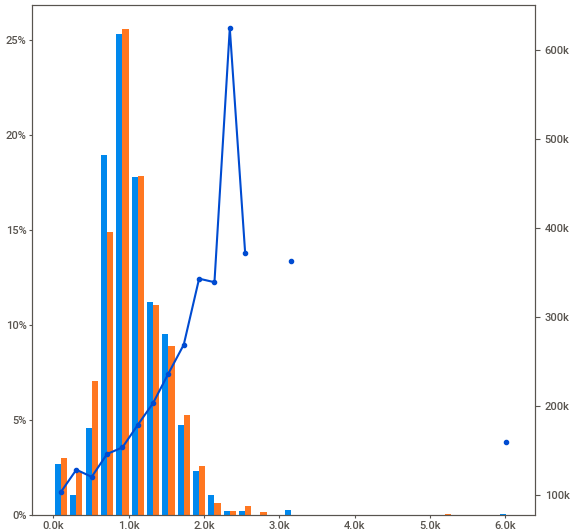
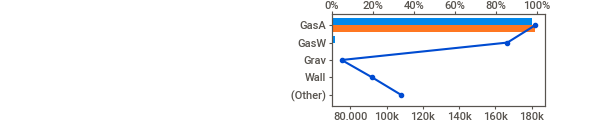
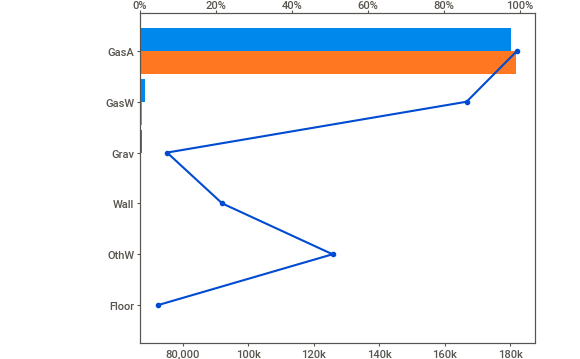
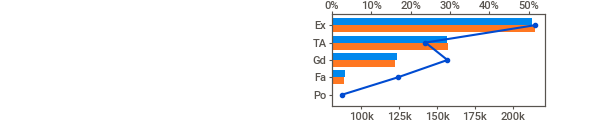
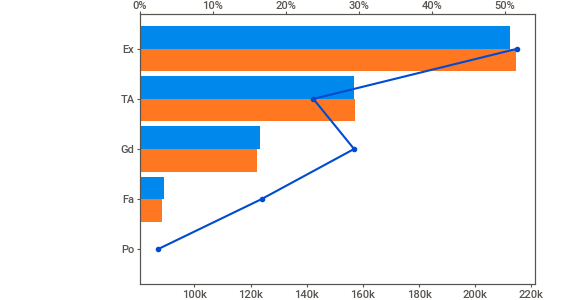
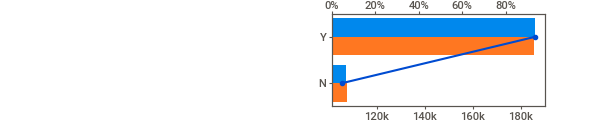
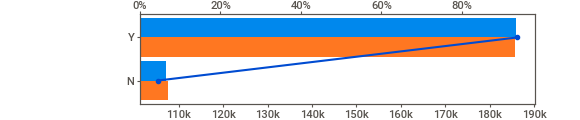
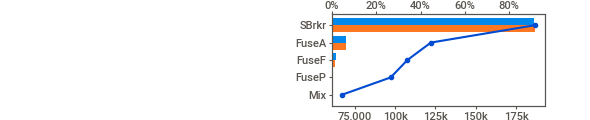
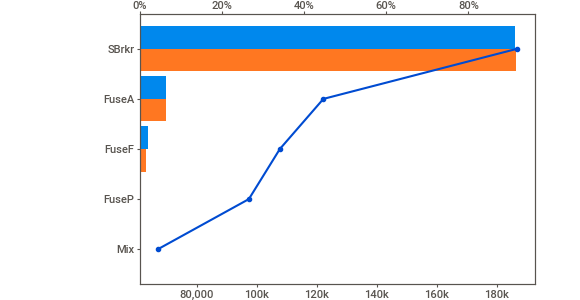
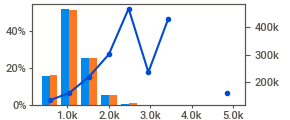
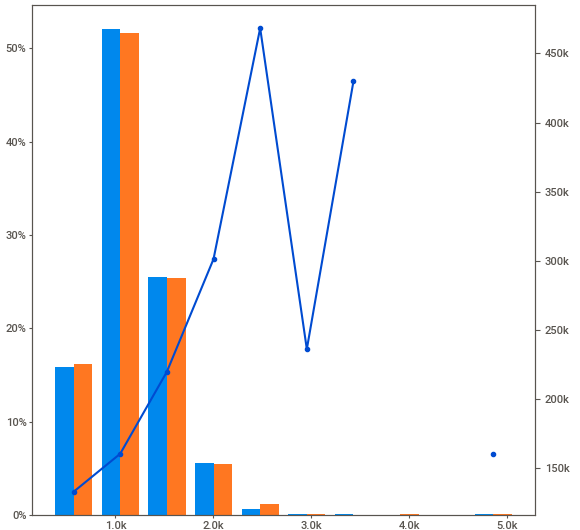
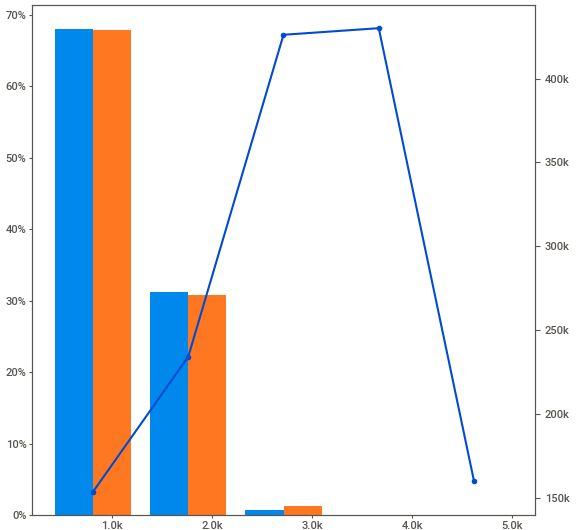
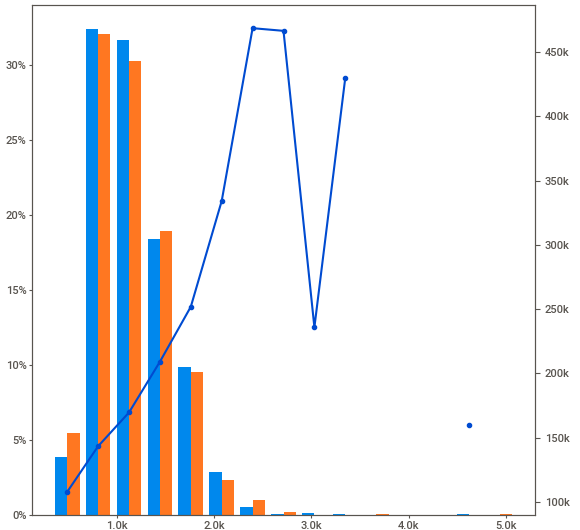
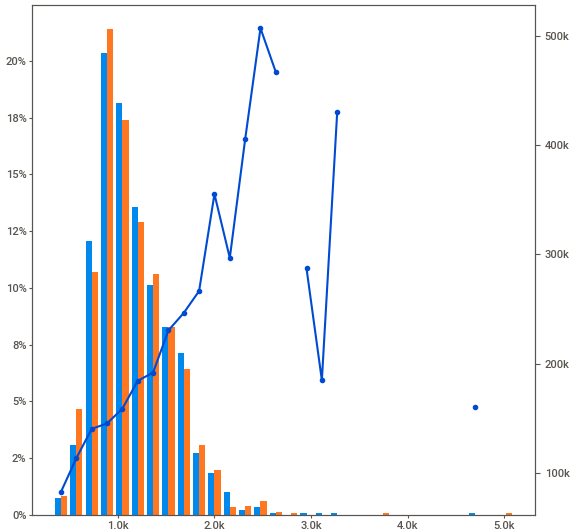
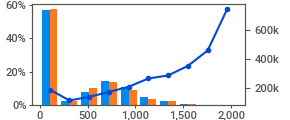
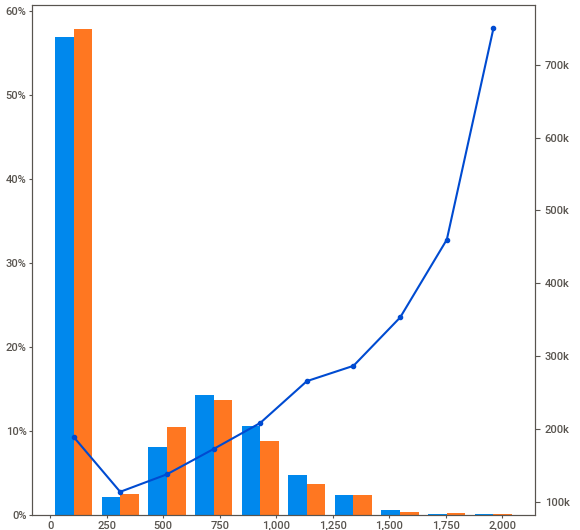
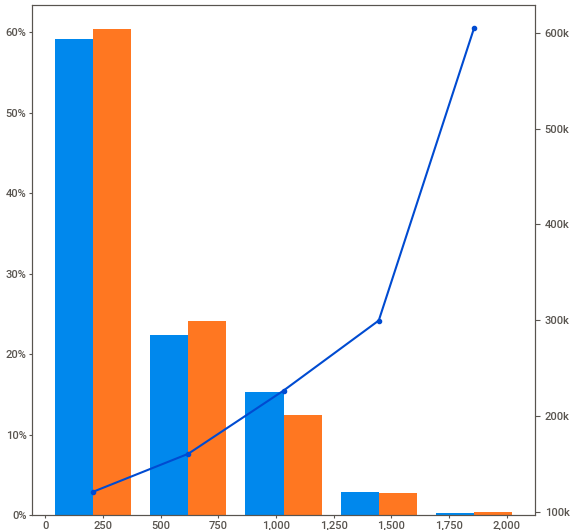
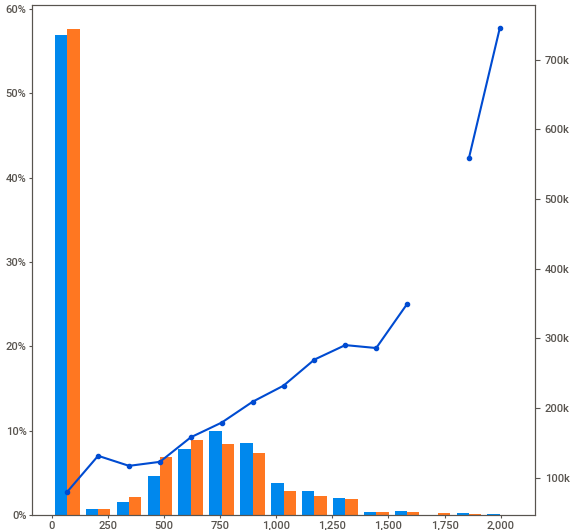
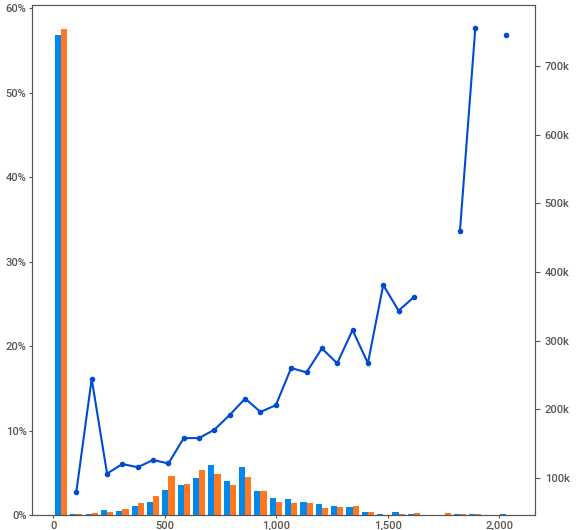
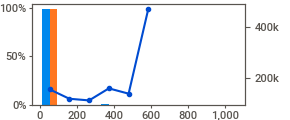
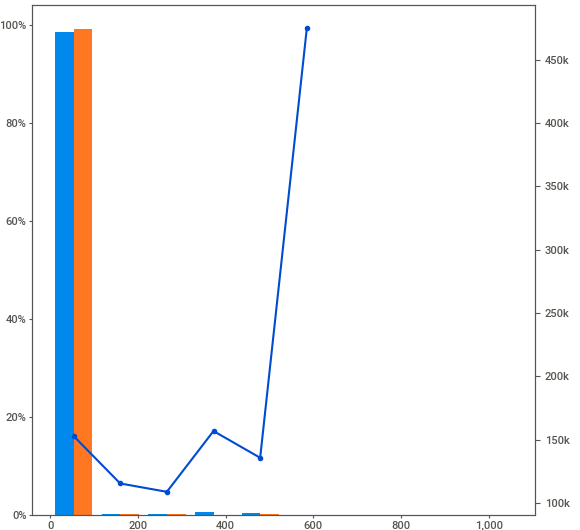
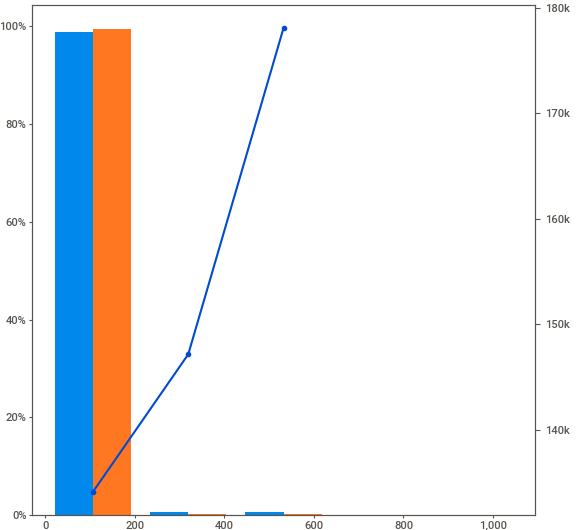
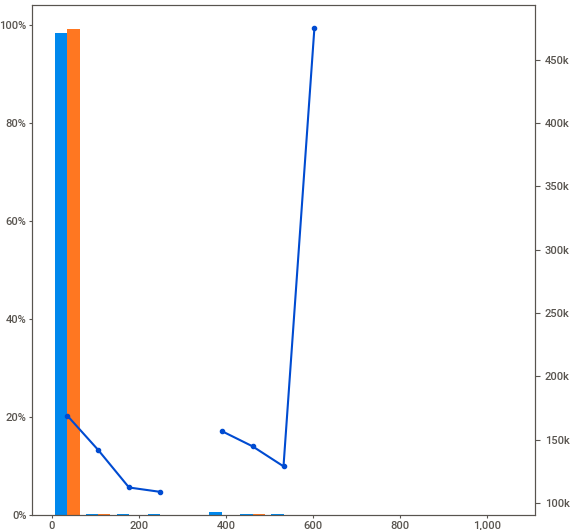
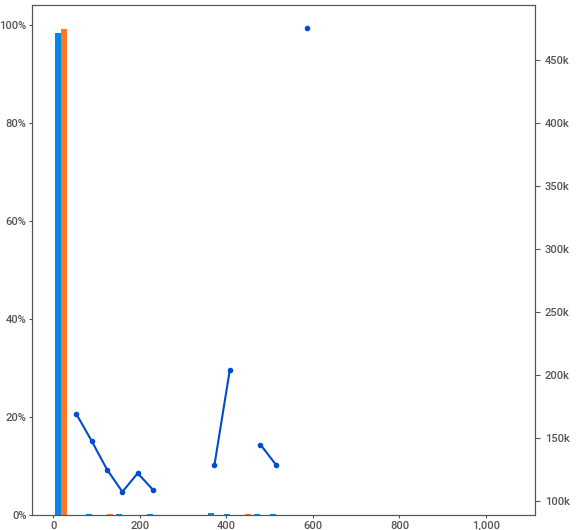
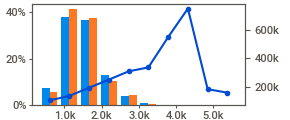
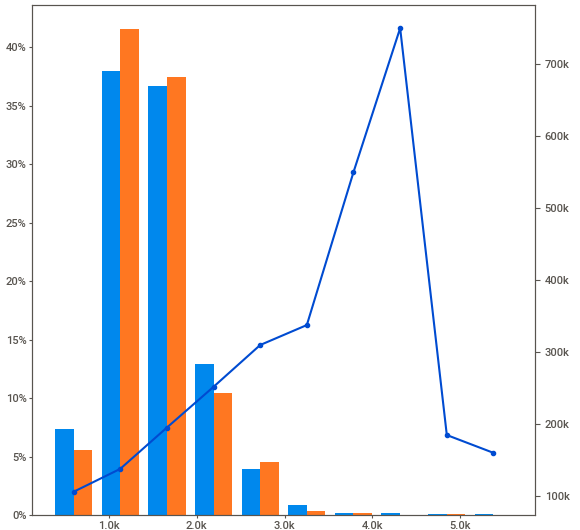
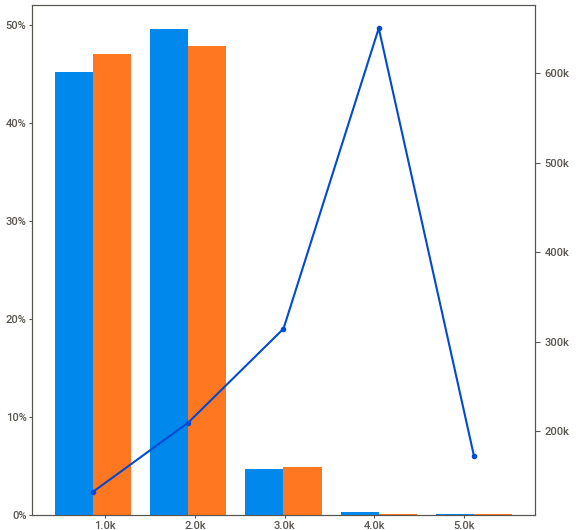
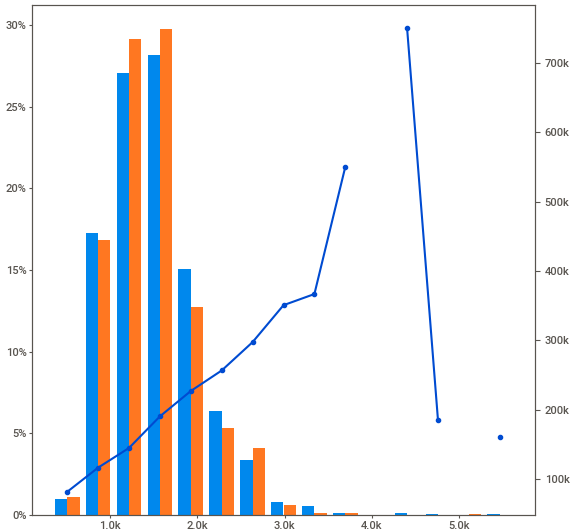
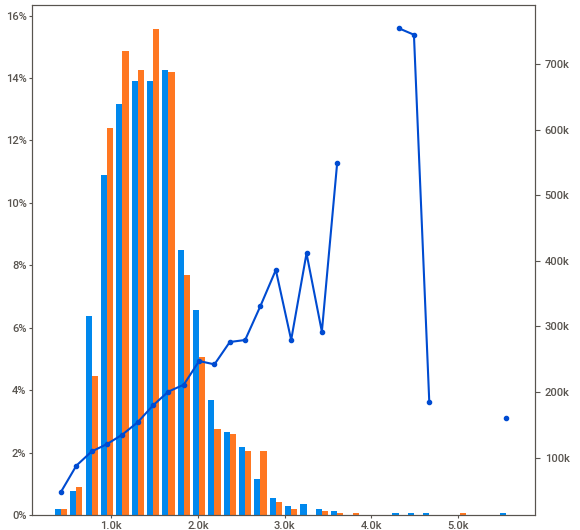
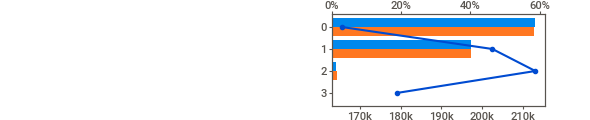
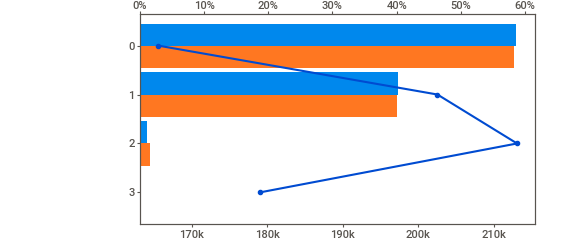
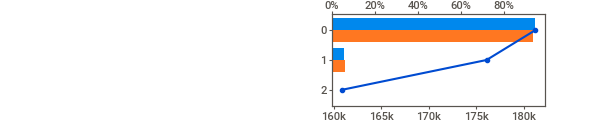
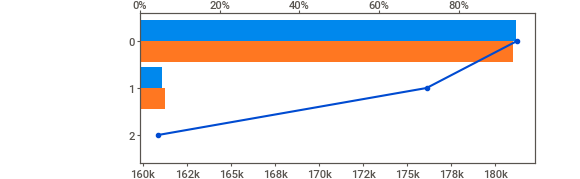
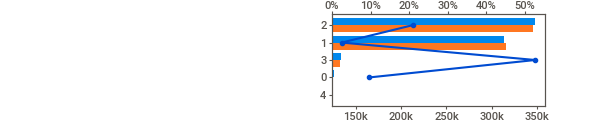
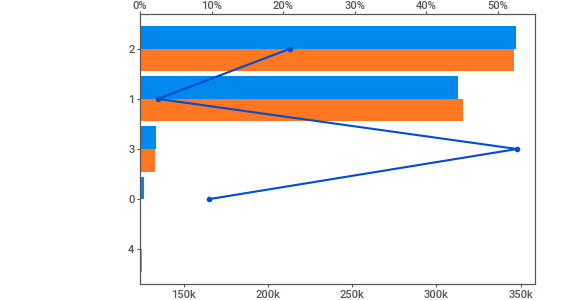
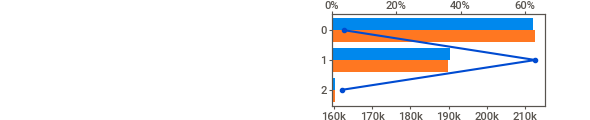
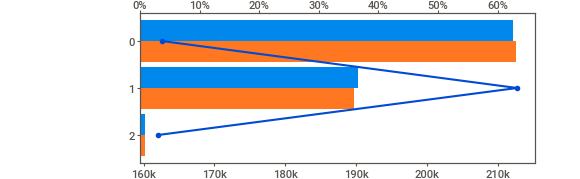
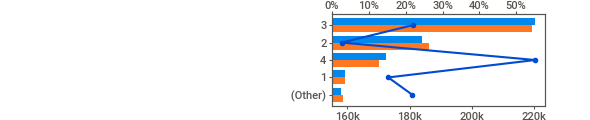
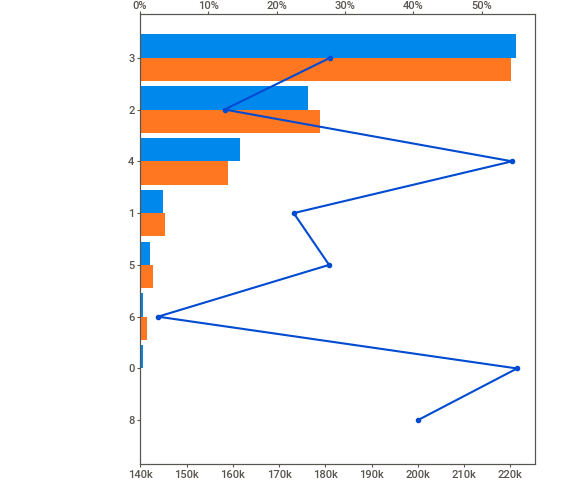
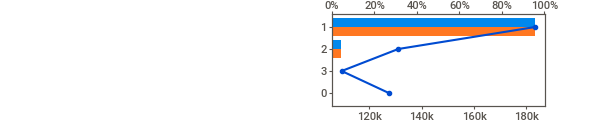
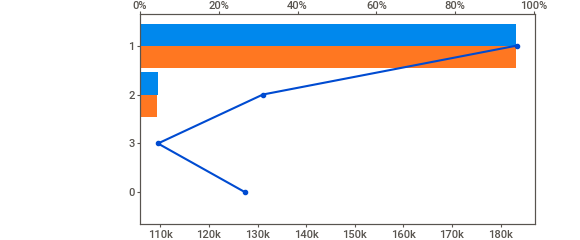
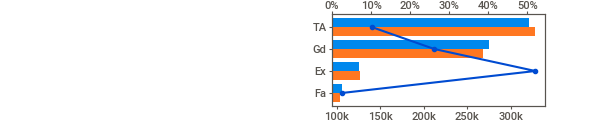
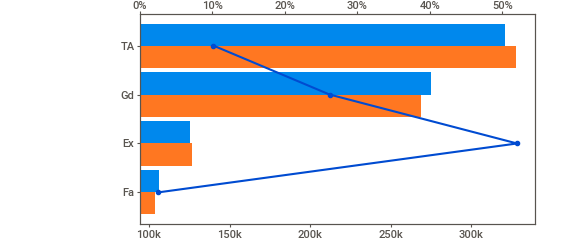
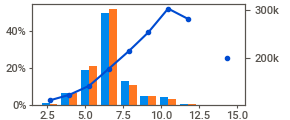
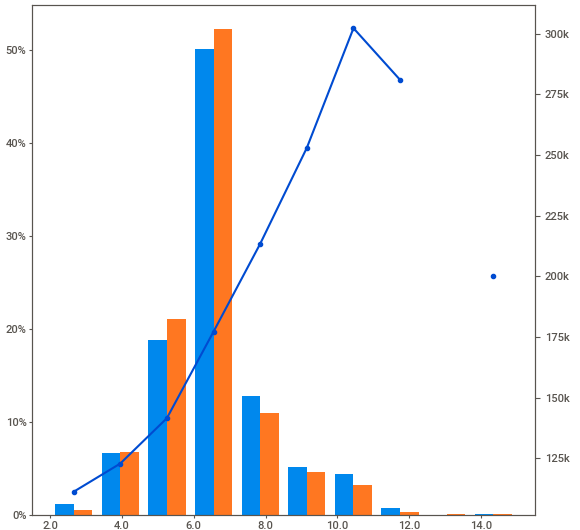
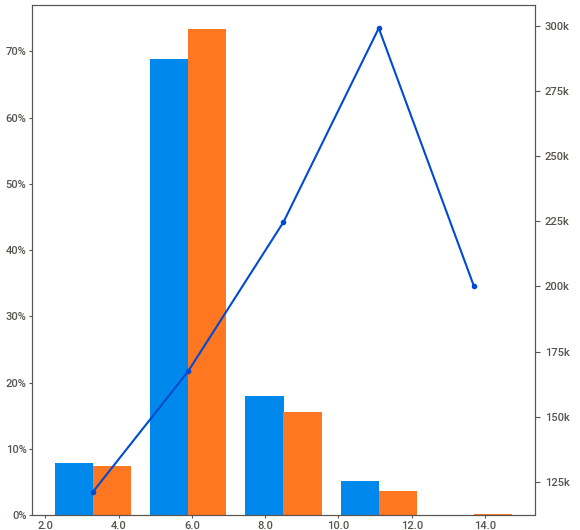
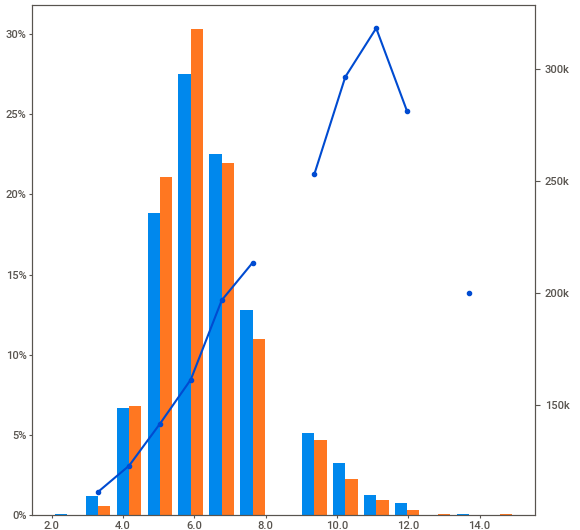
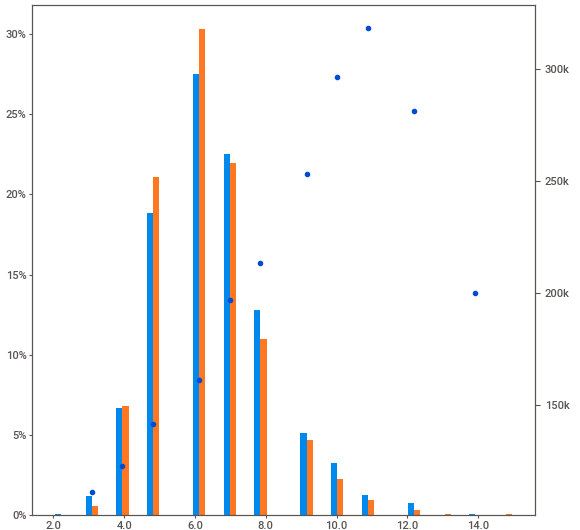
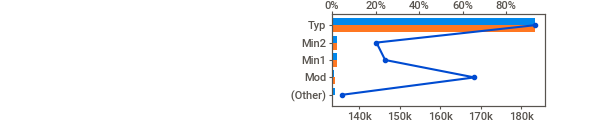
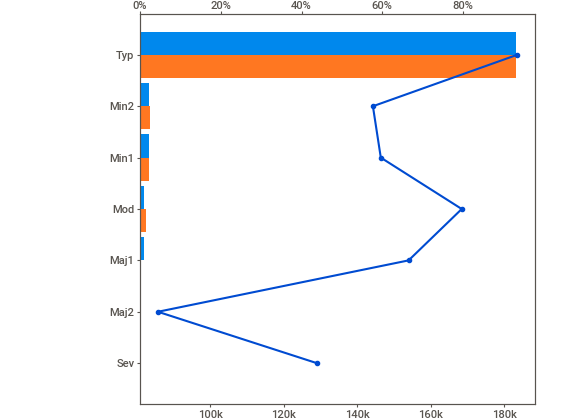
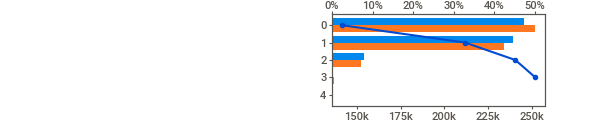
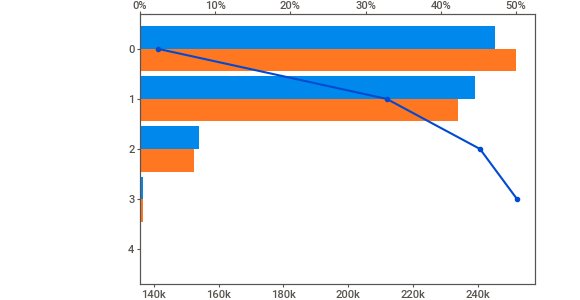
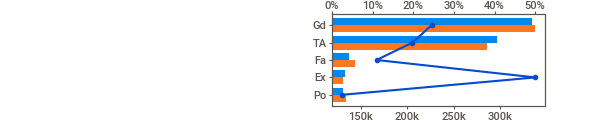
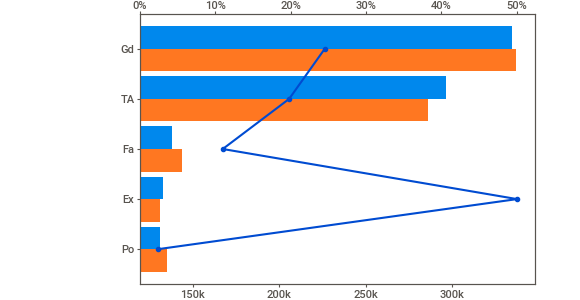
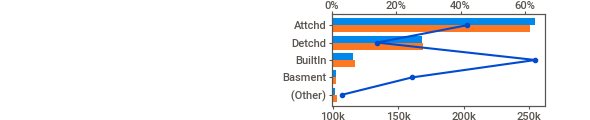
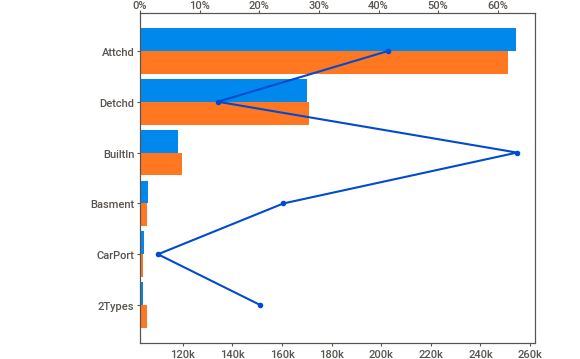
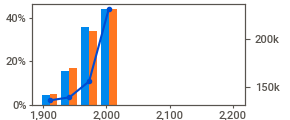
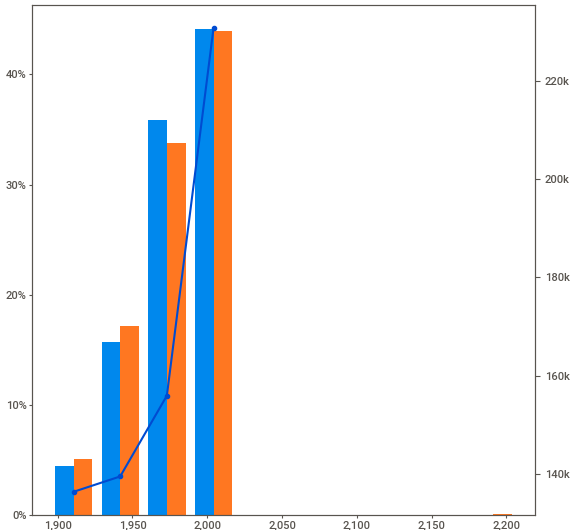
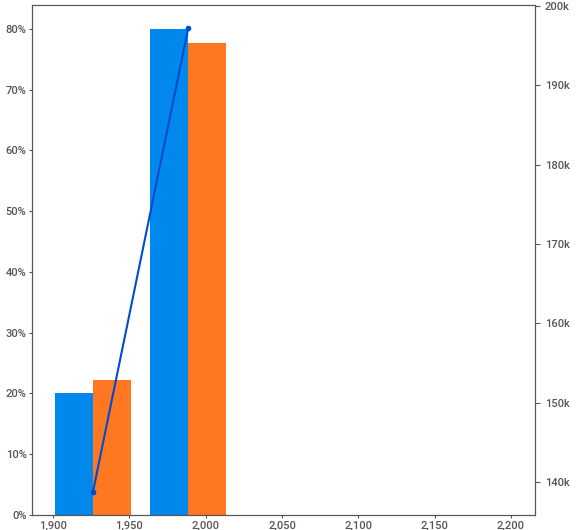
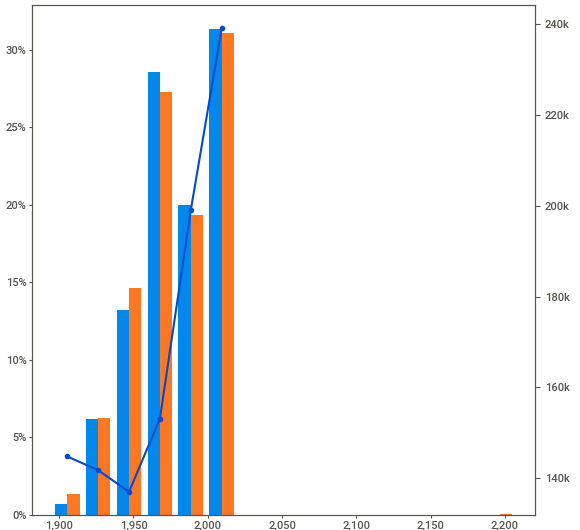
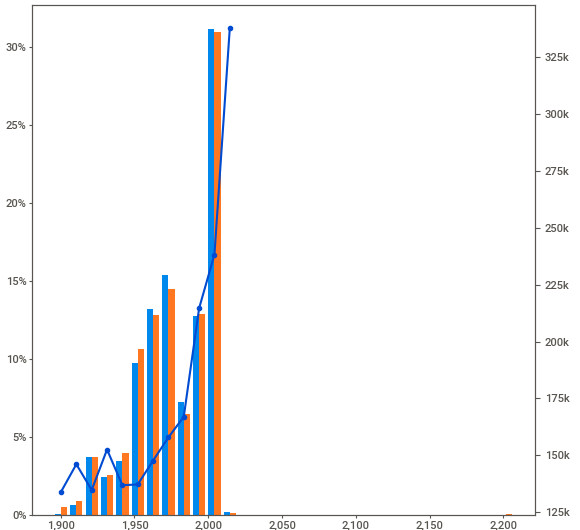
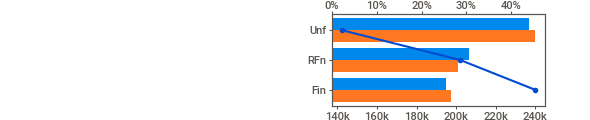
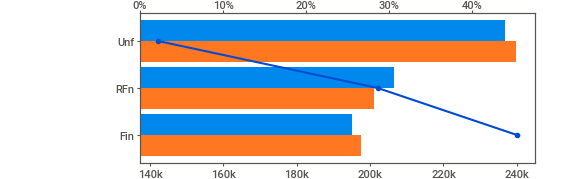
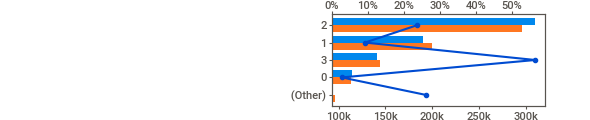
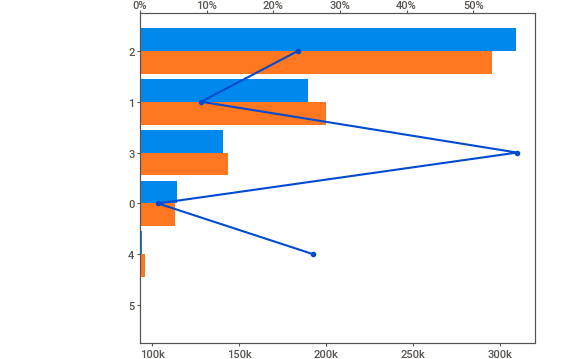
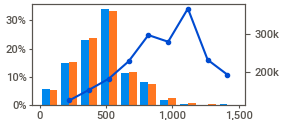
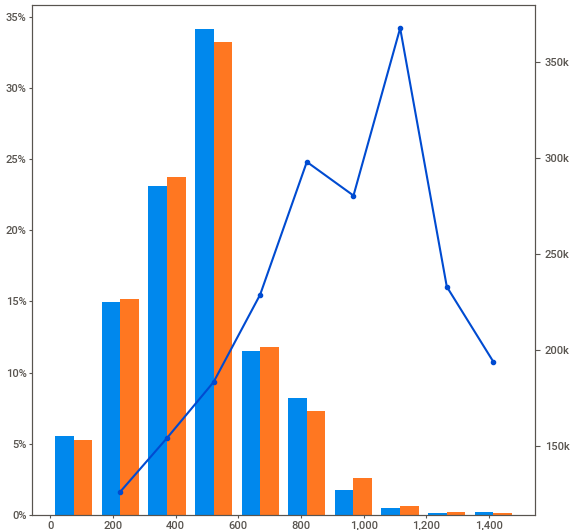
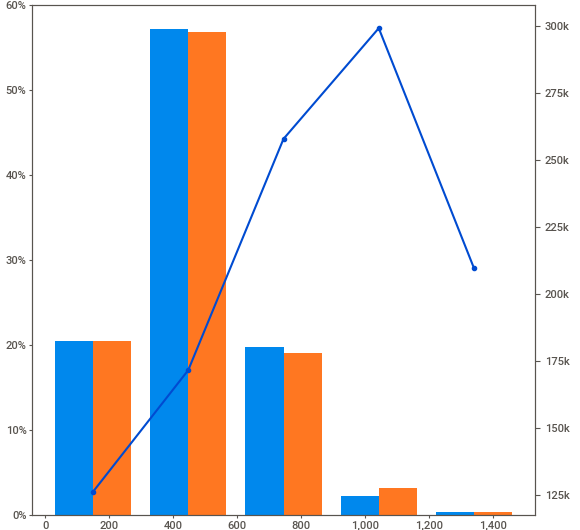
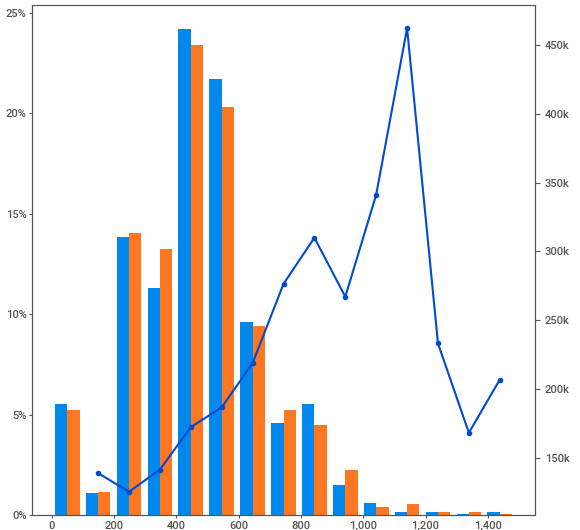
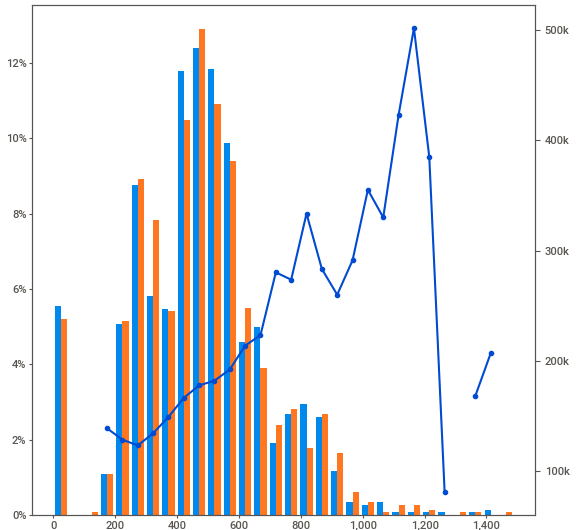
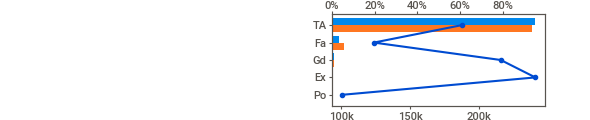
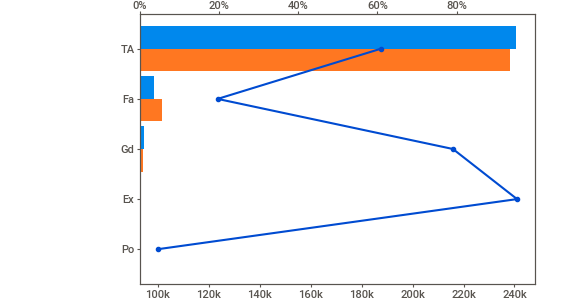
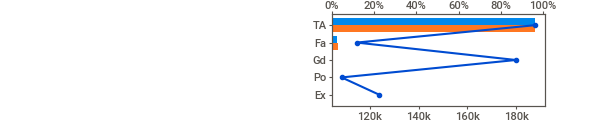
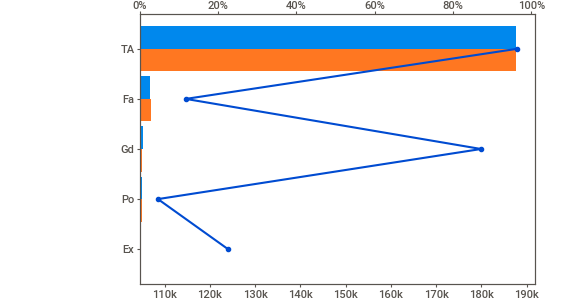
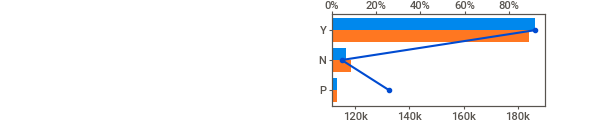
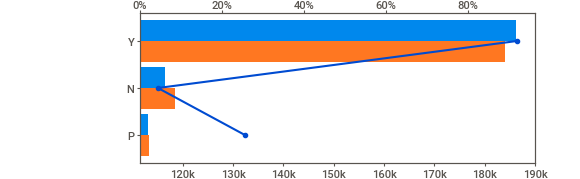
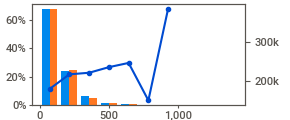
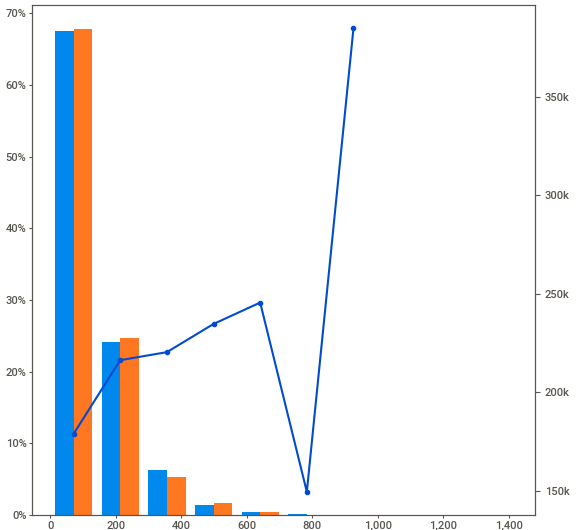
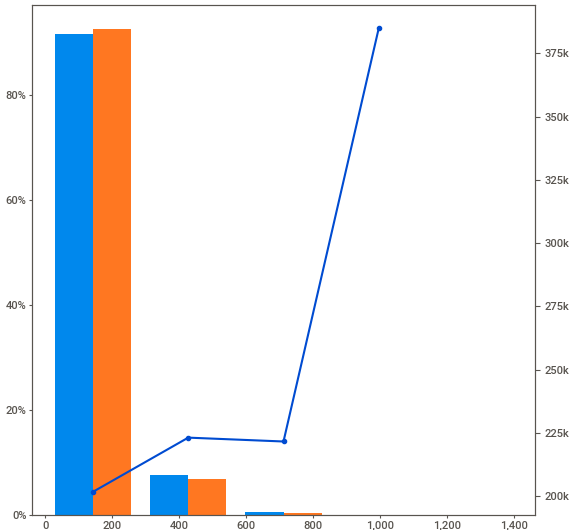
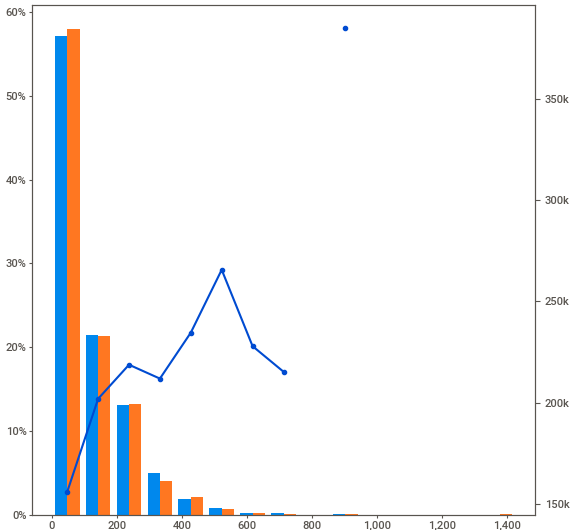
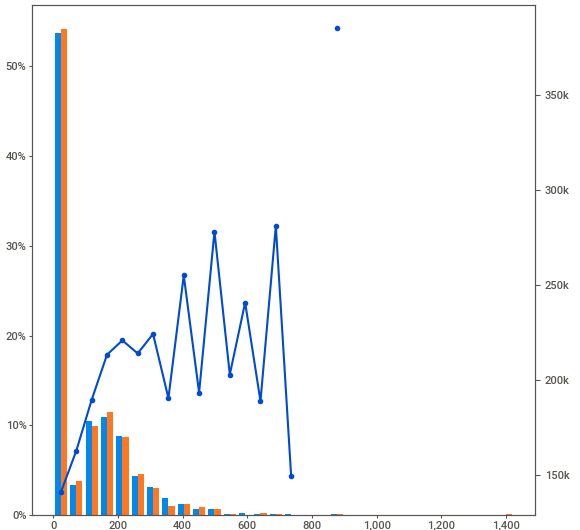
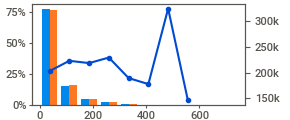
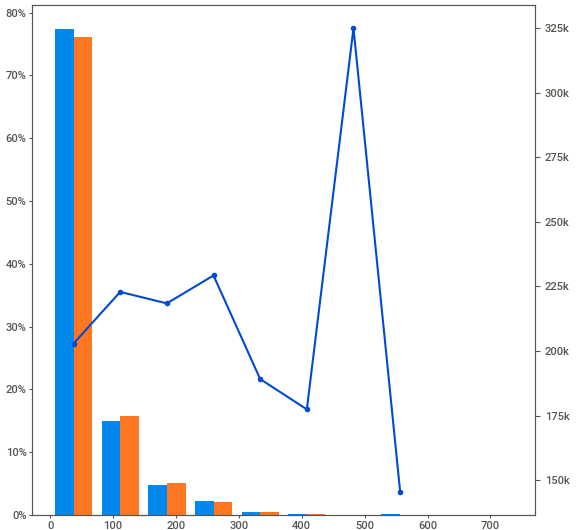
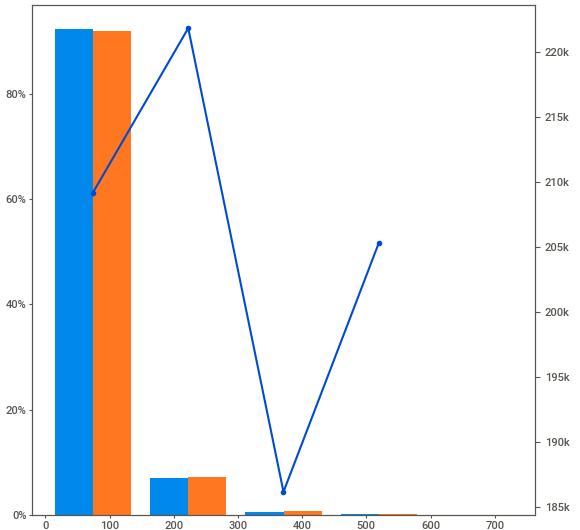
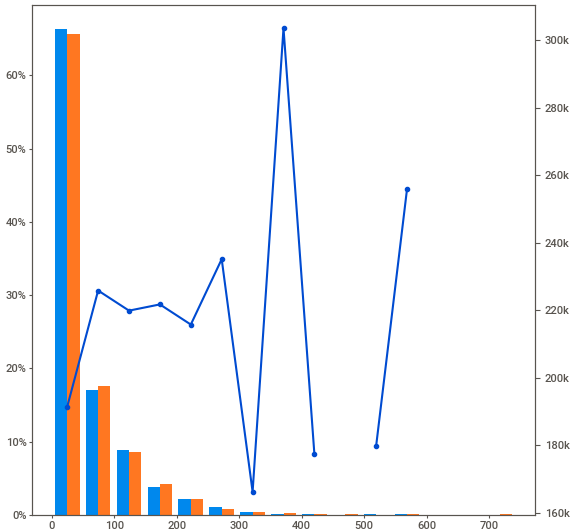
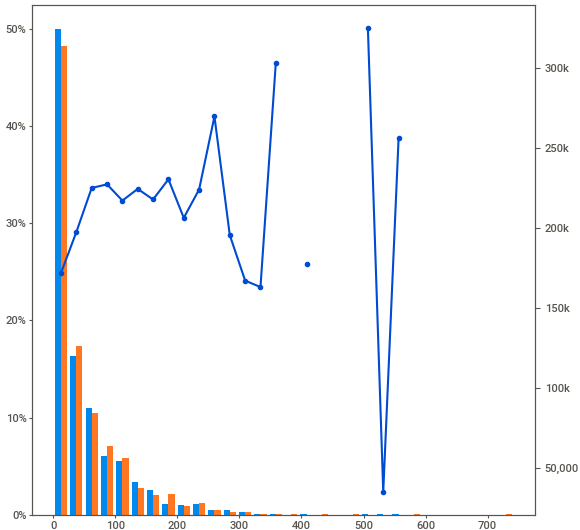
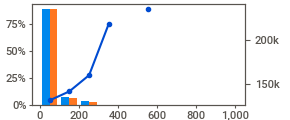
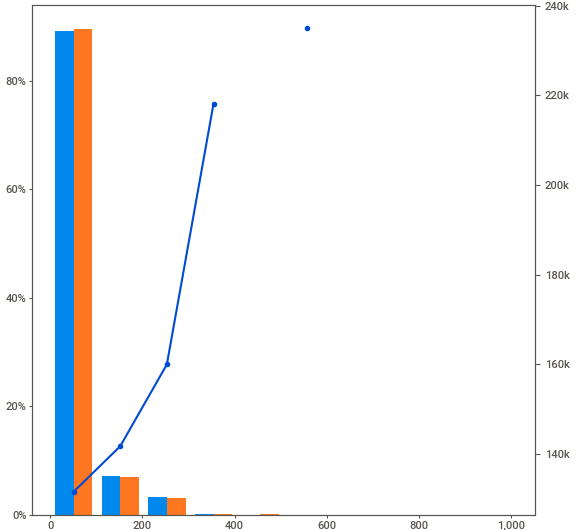
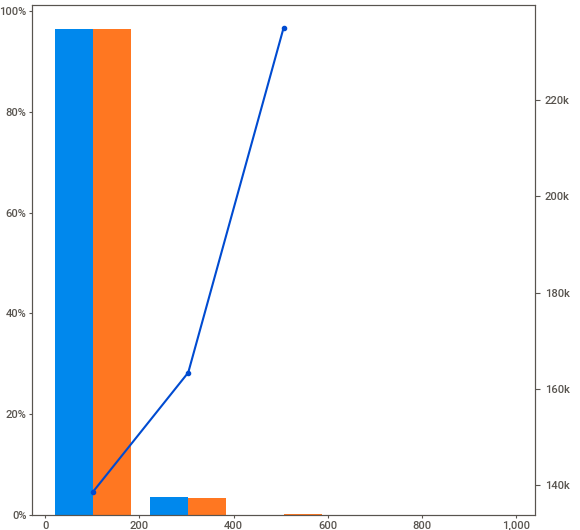
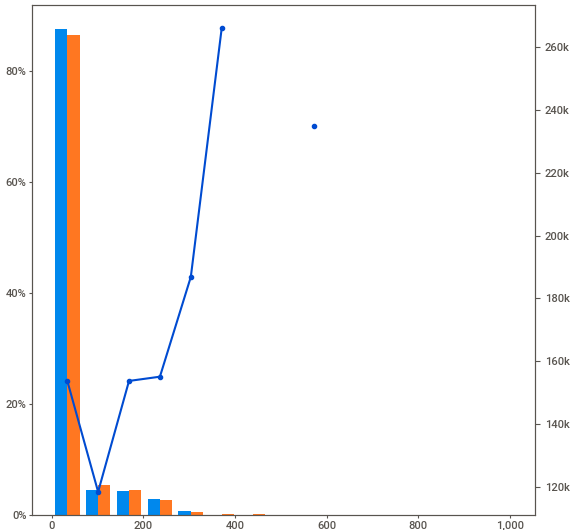
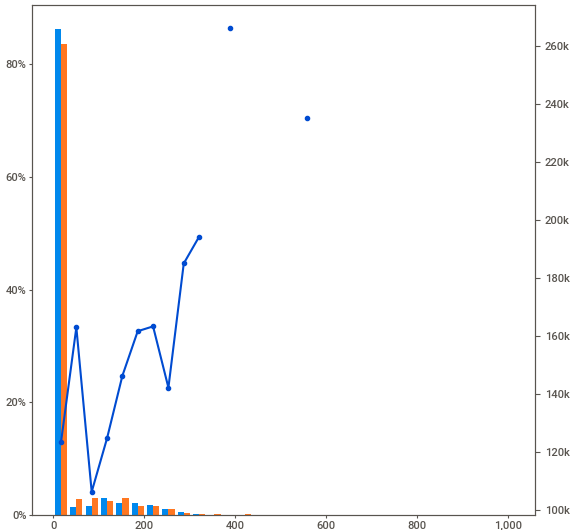
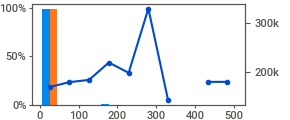
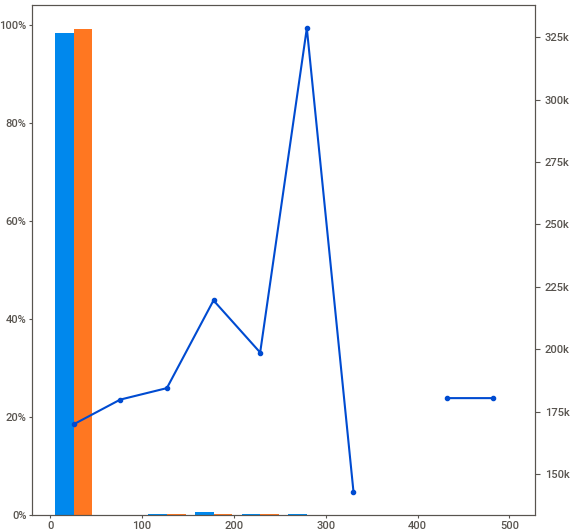
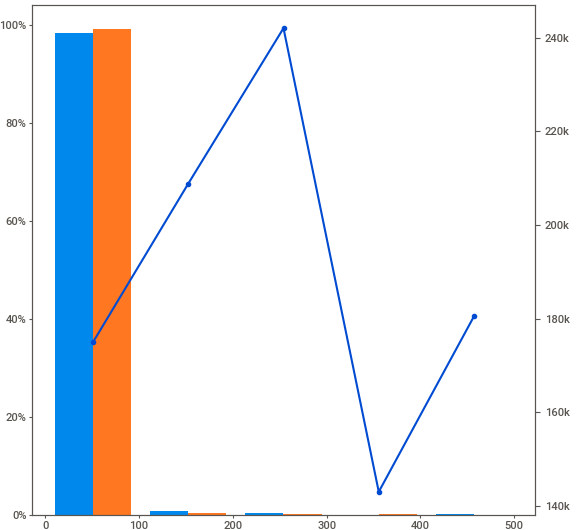
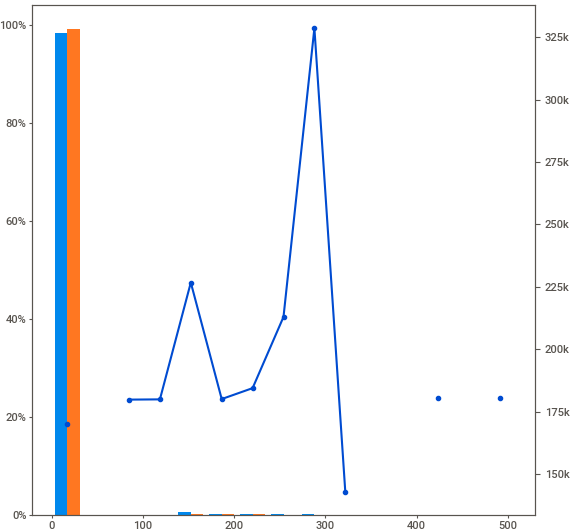
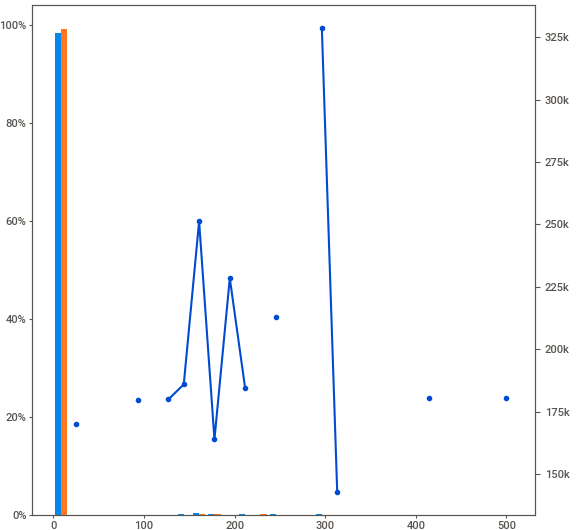
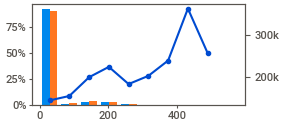
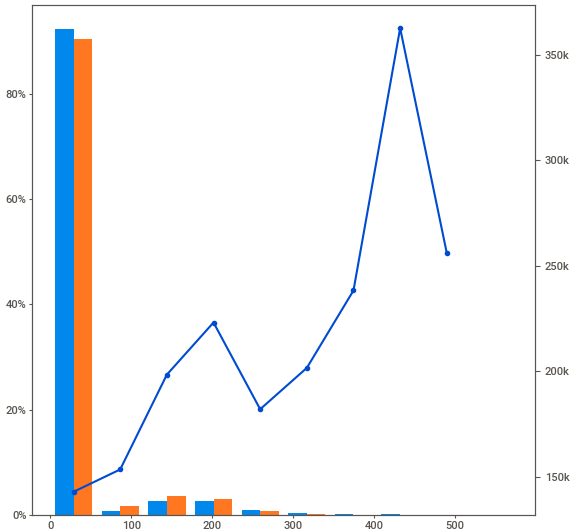
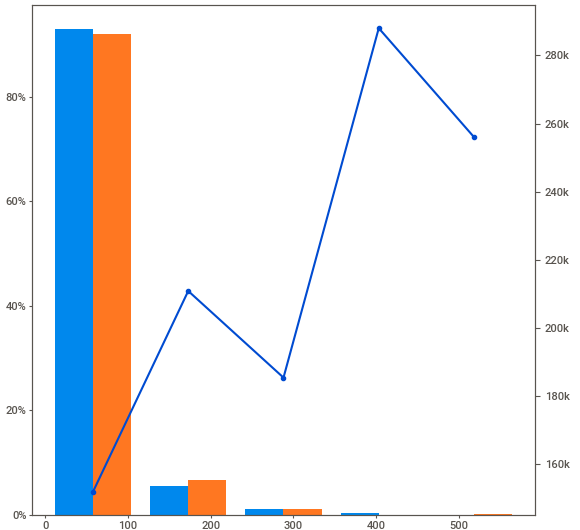
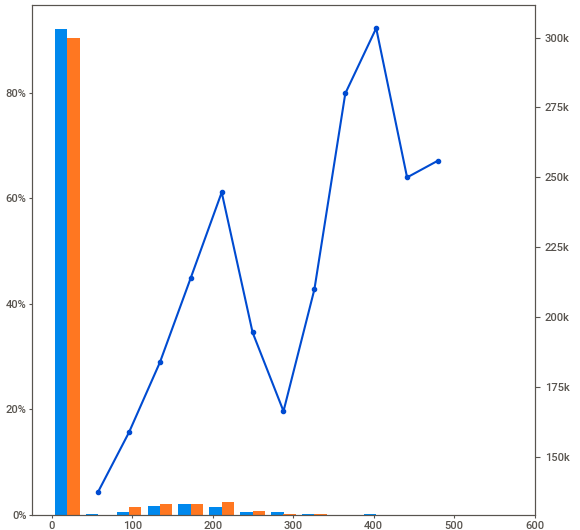
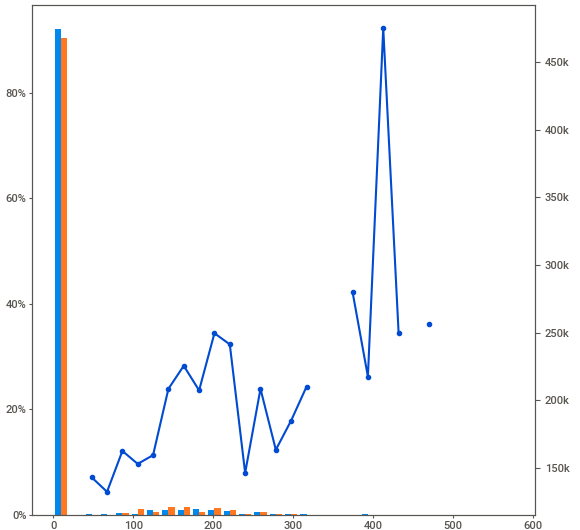
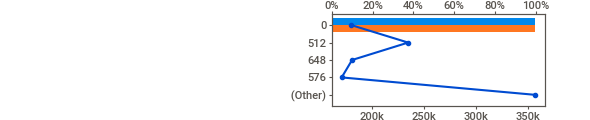
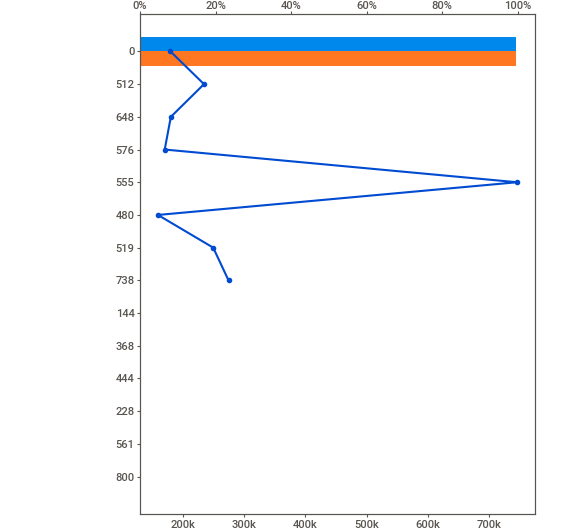
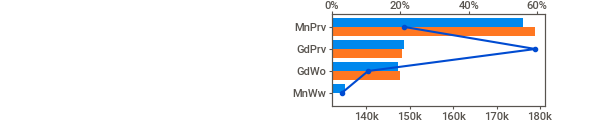
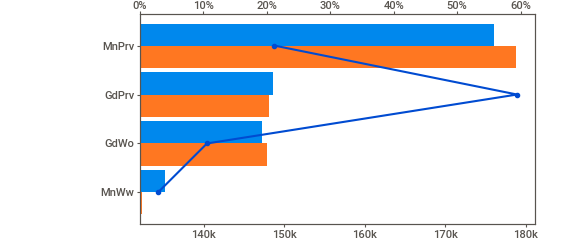
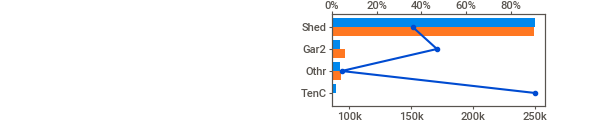
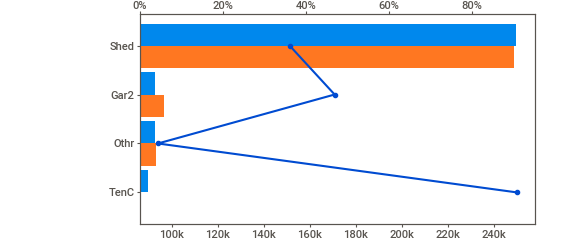
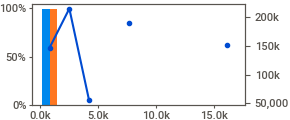
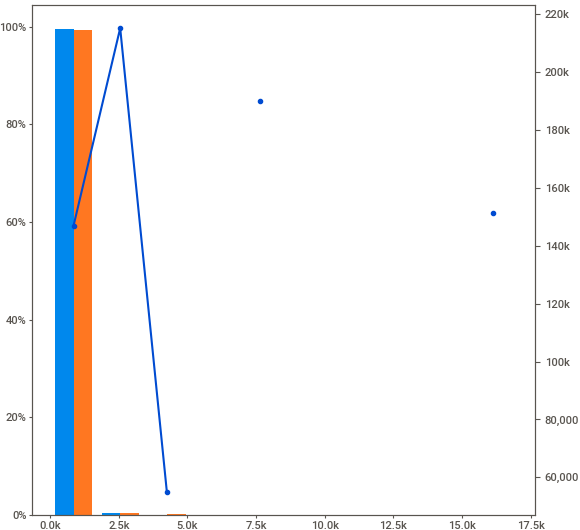
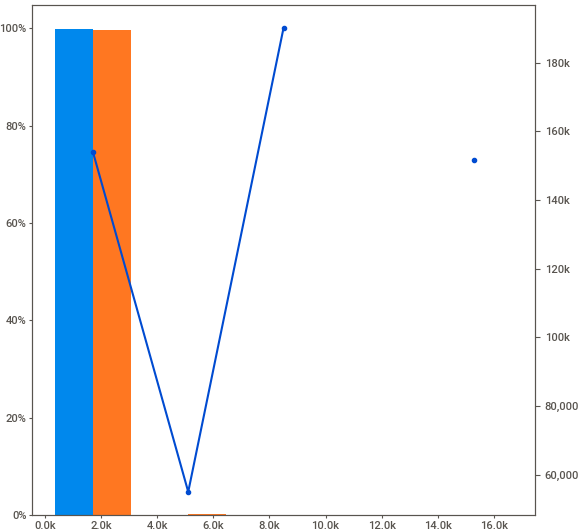
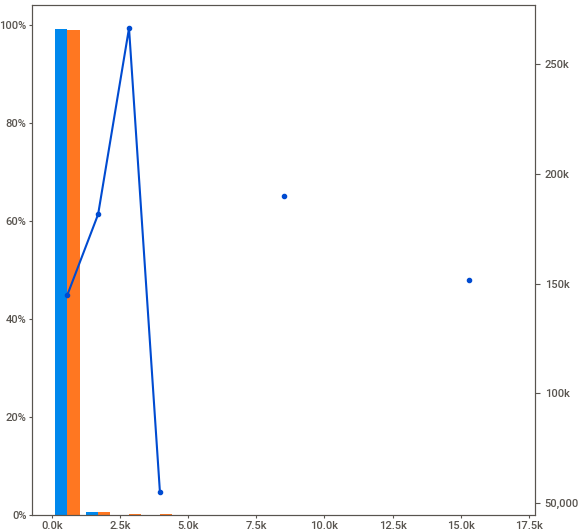
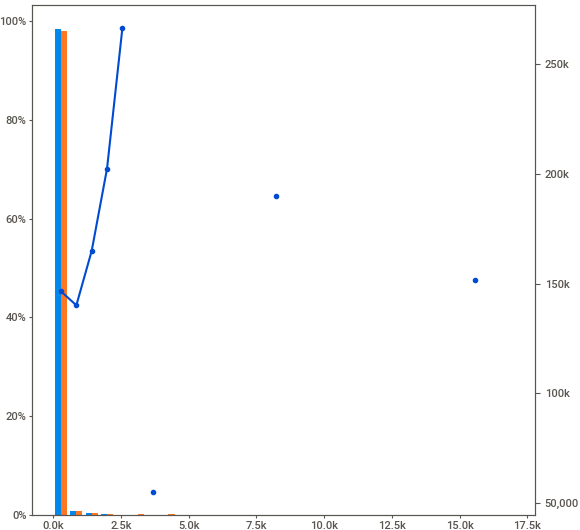
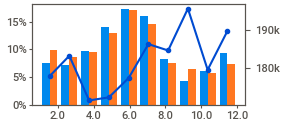
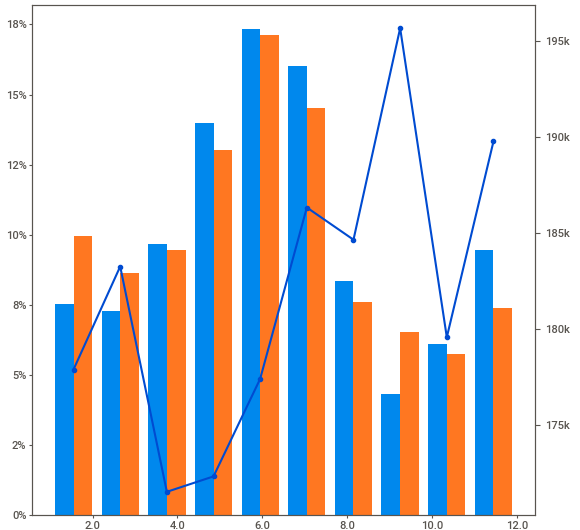
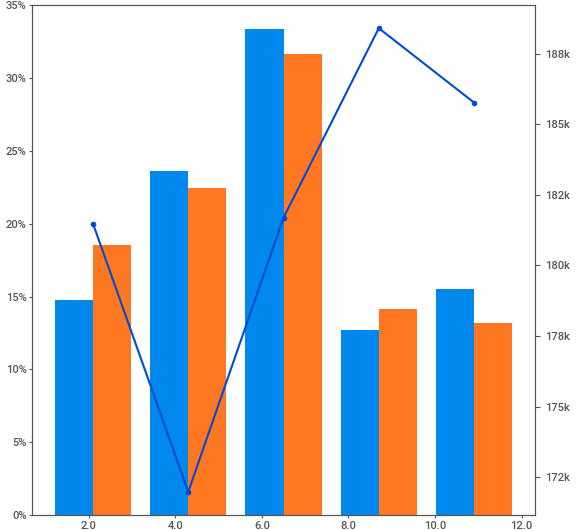
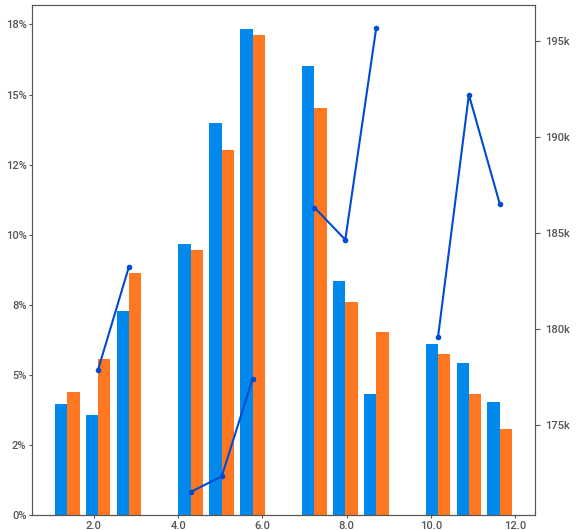
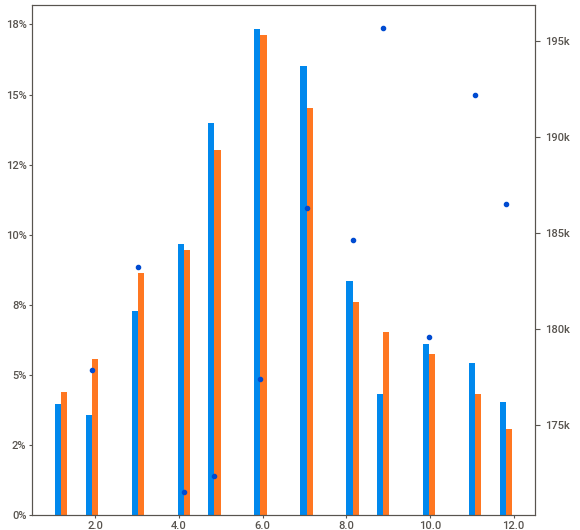
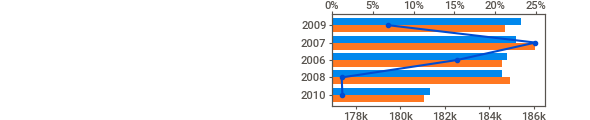
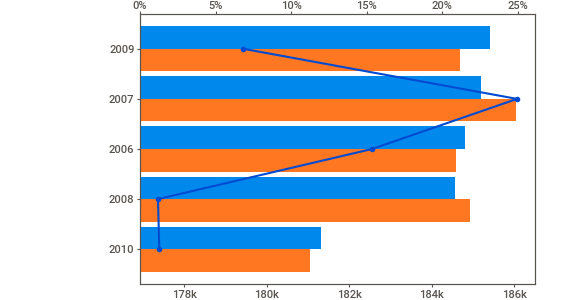
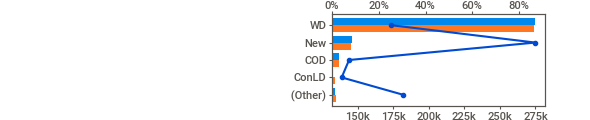
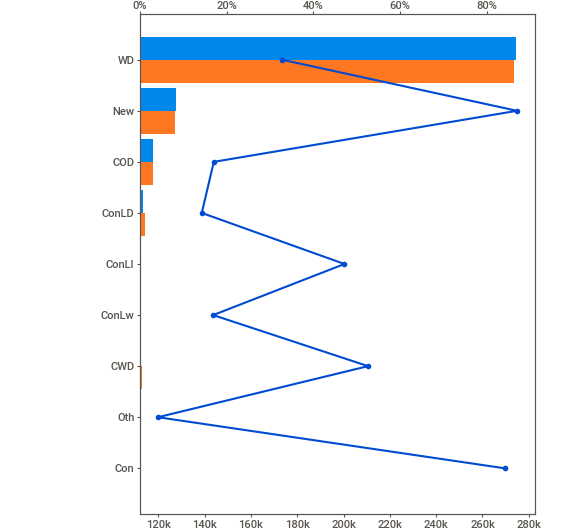
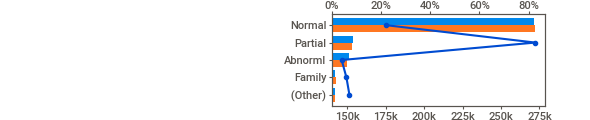
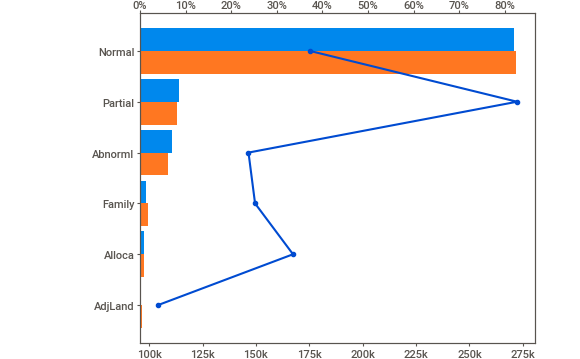
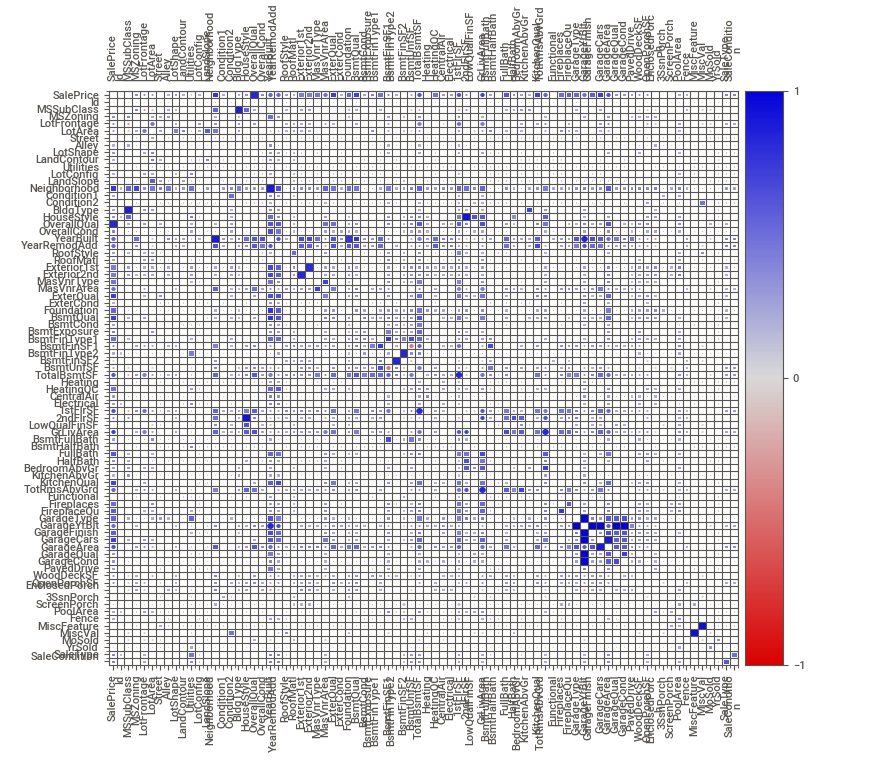
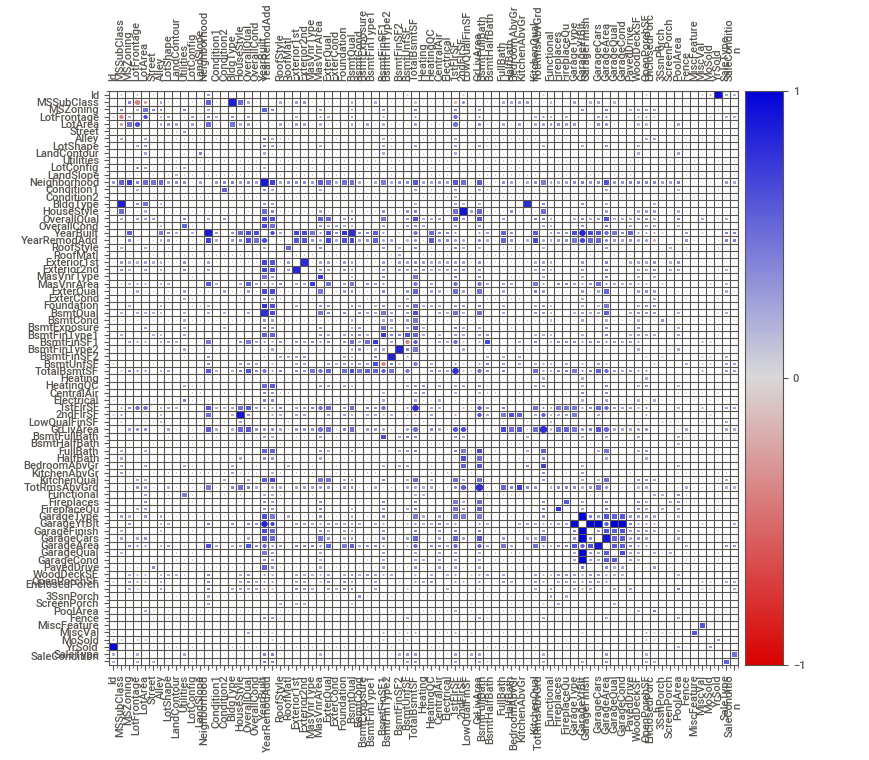

In [10]:
#my_report = sweetviz.analyze(train_df, "SalePrice")
my_report = sweetviz.compare([train_df, "Train"], [test_df, "Test"], "SalePrice")
my_report.show_notebook()

<a id ="3.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.2 Feature Selection</center></h2>

In [11]:
## Drop the columns which contain null values more than 500.
def feature_selection(dataframe):
    df = dataframe.copy()
    for column in df.columns:
        n_null = train_df[column].isnull().sum()
        if n_null > 500:
            df = df.drop([column], axis=1)
    return df

## Feature selection on train data
train = feature_selection(train_df)
print(len(train_df.columns), len(train.columns))

81 76


In [12]:
## Feature selection on test data
feature_list = list(train.columns)
feature_list.remove('SalePrice')
test = test_df[feature_list]

In [13]:
## Select numerical and categorical features
def get_numerical_categorical(df, feature_list, n_unique=False):
    numerical_features = []
    categorical_features = []
    for column in feature_list:
        if n_unique:
            if df[column].nunique() > n_unique:
                numerical_features.append(column)
            else:
                categorical_features.append(column)
        else:
            if df[column].dtypes == 'object': 
                categorical_features.append(column)
            else:
                numerical_features.append(column)
    return numerical_features, categorical_features

target = 'SalePrice'

## Features which has more than 30 unique values as numerical
numerical_features, categorical_features = get_numerical_categorical(train,
                                                                     feature_list,
                                                                     n_unique=30)
numerical_features.remove('Id')
print(len(numerical_features), len(categorical_features))

18 56


In [14]:
## Numerical features' dtype check 
for n in range(len(numerical_features)):
    print(numerical_features[n])
    print(train[numerical_features[n]].dtypes)
    print()

LotFrontage
float64

LotArea
int64

YearBuilt
int64

YearRemodAdd
int64

MasVnrArea
float64

BsmtFinSF1
int64

BsmtFinSF2
int64

BsmtUnfSF
int64

TotalBsmtSF
int64

1stFlrSF
int64

2ndFlrSF
int64

GrLivArea
int64

GarageYrBlt
float64

GarageArea
int64

WoodDeckSF
int64

OpenPorchSF
int64

EnclosedPorch
int64

ScreenPorch
int64



In [15]:
## Categoical features' unique values check
for n in range(len(categorical_features)):
    print(categorical_features[n])
    print(train[categorical_features[n]].unique())
    print()

MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']

Street
['Pave' 'Grvl']

LotShape
['Reg' 'IR1' 'IR2' 'IR3']

LandContour
['Lvl' 'Bnk' 'Low' 'HLS']

Utilities
['AllPub' 'NoSeWa']

LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope
['Gtl' 'Mod' 'Sev']

Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']

Condition1
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']

Condition2
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']

BldgType
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

HouseStyle
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']

OverallQual
[ 7  6  8  5  9  4 10  3  1  2]

OverallCond
[5 8 6 7 4 2 3 9 1]

RoofStyle
['Gable' 'Hip' 'Gambrel' 'Mansa

<a id ="3.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.3 Target Distribution</center></h2>

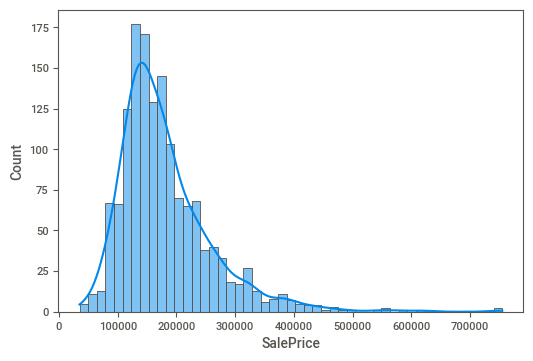

In [16]:
sns.histplot(x=target, data=train, kde=True)
plt.show()

#### [Box-Cox Transformation](https://qiita.com/dyamaguc/items/b468ae66f9ce6ee89724) on 'SalePrice'

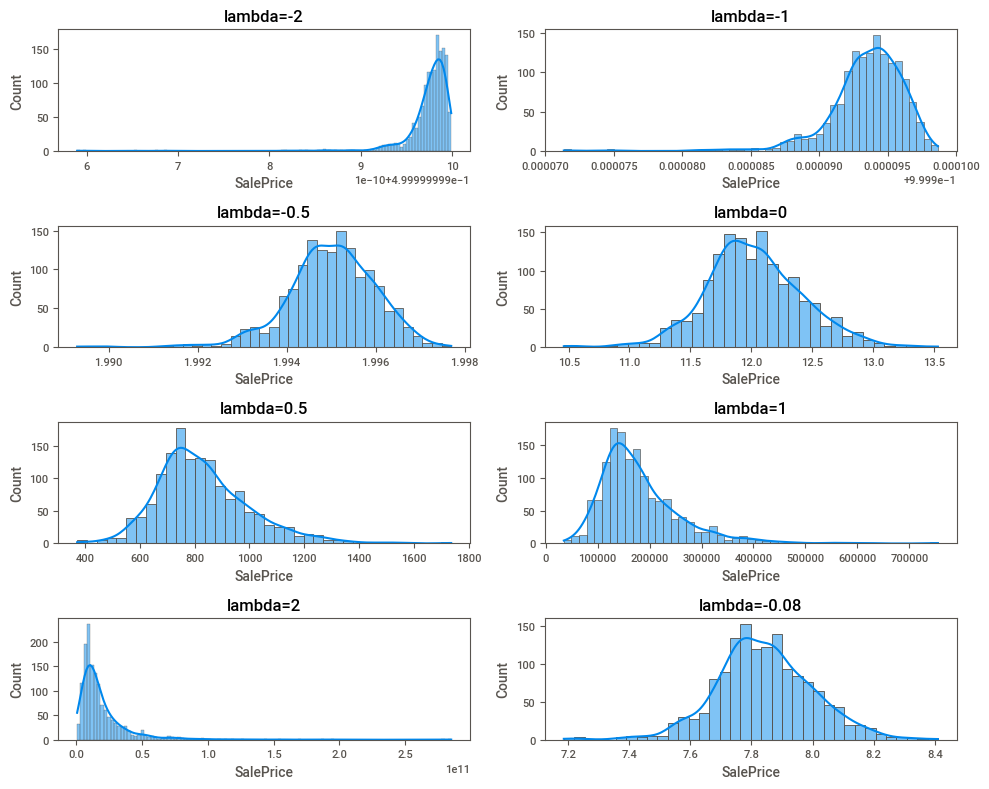

In [17]:
fig = plt.figure(figsize=(10, 8))

list_lambda = [-2, -1, -0.5, 0, 0.5, 1, 2]
for i, lmbda in enumerate(list_lambda):
    boxcox = sp.stats.boxcox(train[target], lmbda=lmbda)
    ax = fig.add_subplot(4, 2, i+1)
    sns.histplot(data=boxcox, kde=True, ax=ax)
    plt.title('lambda='+str(list_lambda[i]))
    plt.xlabel('SalePrice')
    
auto_boxcox, best_lambda = sp.stats.boxcox(train[target], lmbda=None)
ax = fig.add_subplot(4, 2, 8)
sns.histplot(data=auto_boxcox, kde=True, ax=ax)
plt.title('lambda=' + str(round(best_lambda, 2)))
plt.xlabel('SalePrice')
    
fig.tight_layout()

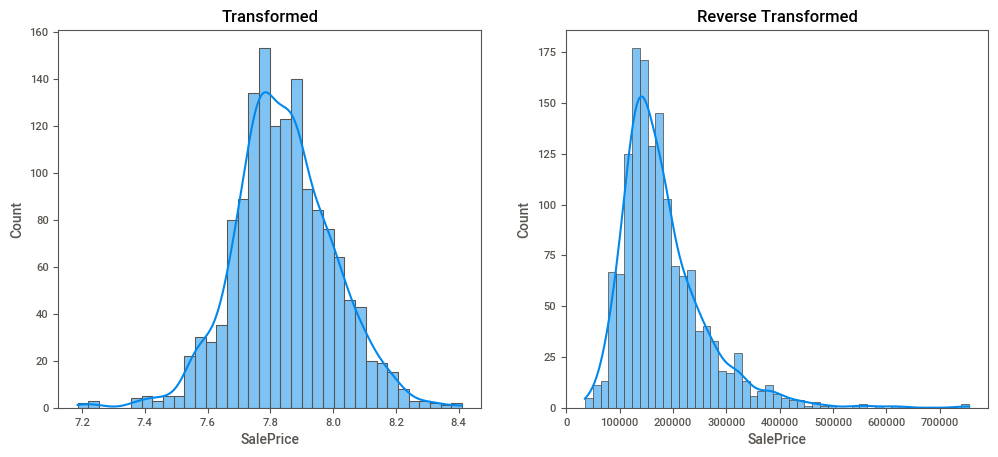

In [18]:
## Box-Cox Summary
fig = plt.figure(figsize=(12, 5))

## Box-Cox Transformation
auto_boxcox, best_lambda = sp.stats.boxcox(train[target], lmbda=None)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(data=auto_boxcox, kde=True, ax=ax)
plt.title('Transformed')
plt.xlabel('SalePrice')

## Reverse Transformation
x = sp.special.inv_boxcox(auto_boxcox, best_lambda)
ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=x, data=train, kde=True, ax=ax)
plt.title('Reverse Transformed')
plt.xlabel('SalePrice')

plt.show()

In [19]:
train_target = pd.DataFrame()

## Box-Cox Transformation on target ('SalePrice')
auto_boxcox, best_lambda = sp.stats.boxcox(train[target], lmbda=None)
train_target['target_transformed'] = auto_boxcox

## Reverse Transformation
#x = sp.special.inv_boxcox(auto_boxcox, best_lambda)

## Box-Cox + Standardization
box_cox_mean = train_target['target_transformed'].mean()
box_cox_std = train_target['target_transformed'].std()
train_target['target_transformed_standardized'] = (train_target['target_transformed'] - box_cox_mean) / box_cox_std

<a id ="3.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.4 Numerical Features</center></h2>

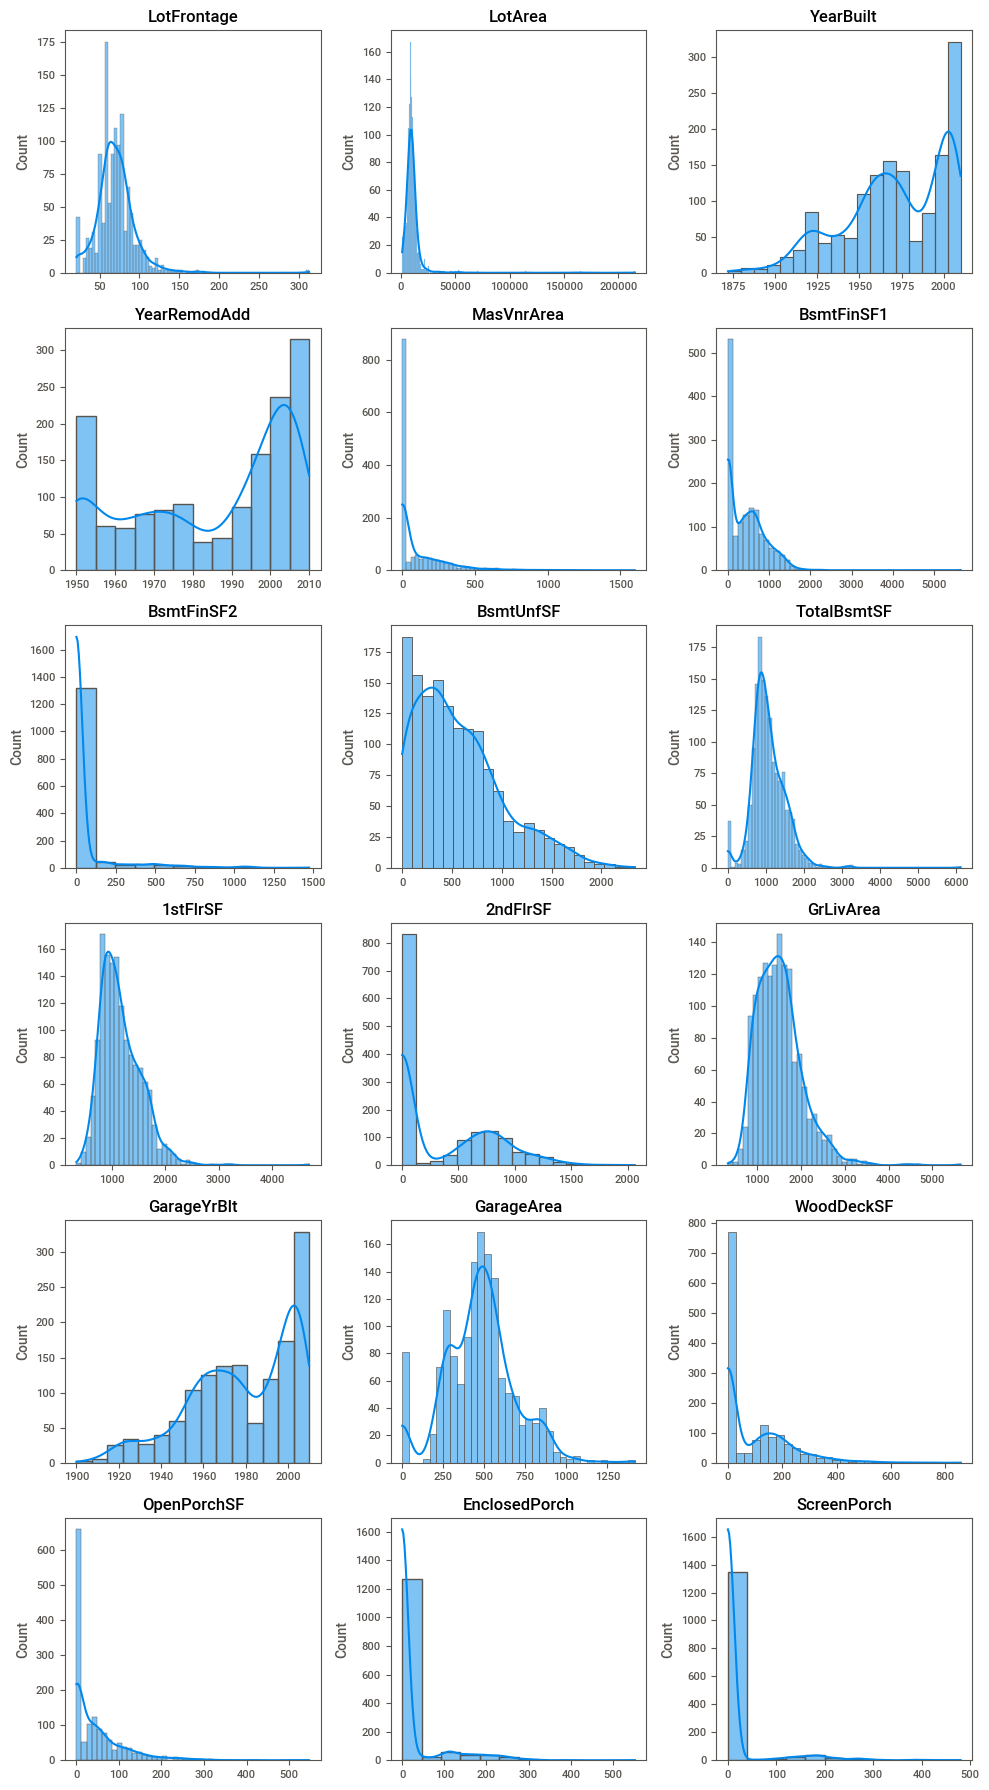

In [20]:
## Distributions of numerical features
fig = plt.figure(figsize=(10, 18))
for i, nf in enumerate(numerical_features):
    ax = fig.add_subplot(6, 3, i+1)
    sns.histplot(train[nf], kde=True, ax=ax)
    plt.title(nf)
    plt.xlabel(None)
fig.tight_layout()

In [21]:
## Heatmap of correlation matrix
numerical_columns = numerical_features + ['SalePrice']
train_numerical = train[numerical_columns]

fig = px.imshow(train_numerical.corr(),
                color_continuous_scale='RdBu_r',
                color_continuous_midpoint=0, 
                aspect='auto')
fig.update_layout(height=600, 
                  width=600,
                  title = "Heatmap",                  
                  showlegend=False)
fig.show()

In [22]:
## Statistics of training data
train[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

In [23]:
## Statistics of test data
test[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

In [24]:
## Feature Engineering on interval scales
target_features = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
target_min = train[target_features].min()
test[target_features] = test[target_features] - target_min
train[target_features] = train[target_features] - target_min

train[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Data Scaling

In [25]:
def data_scaling(dataframe,
                 numerical_features,
                 scaling_type='log_transform'):
    df = dataframe.copy()
    numerical_df = df[numerical_features]
    mean_df = numerical_df.mean()
    #var_df = numerical_df.var()
    std_df = numerical_df.std()
    min_df = numerical_df.min()
    max_df = numerical_df.max()
    quantiles = numerical_df.quantile([0.05, 0.95])
    minus_flg_df = pd.DataFrame(np.where(numerical_df.values < 0, -1, 1), columns=numerical_df.columns)
    
    for nf in numerical_features:
        numerical = numerical_df[nf].values
        
        ## Clipping on (mean ± std * 3)
        if scaling_type == 'clip_std':
            nf_mean = mean_df[nf]
            nf_std = std_df[nf]
            threshold_1 = nf_mean - nf_std * 3
            threshold_2 = nf_mean + nf_std * 3
            numerical = np.where(numerical < threshold_1, threshold_1, numerical)
            nuemrical = np.where(numerical > threshold_2, threshold_2, numerical)
            
        ## Clipping on Quantile
        elif scaling_type == 'clip_quantile':
            threshold_1 = quantiles[nf].values[0]
            threshold_2 = quantiles[nf].values[1]
            numerical = np.where(numerical < threshold_1, threshold_1, numerical)
            numerical = np.where(numerical > threshold_2, threshold_2, numerical)
            
        ## Min-Max Scaling
        elif scaling_type == 'min_max_scaling':
            nf_min = min_df[nf]
            nf_max = max_df[nf]
            numerical = (numerical - nf_min) / (nf_max - nf_min)
            
        ## Logarithmic transformation
        elif scaling_type == 'log_transform':
            numerical = np.log(1 + np.abs(numerical))
            numerical *= minus_flg_df[nf].values
            
        df[nf] = numerical
    
    return df

train = data_scaling(train, numerical_features, scaling_type='log_transform')
test = data_scaling(test, numerical_features, scaling_type='log_transform')

In [26]:
## Statistics of training data after data scaling
train[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

In [27]:
## Statistics of test data after data scaling
test[numerical_features].describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')\
                        .background_gradient(subset=['max'], cmap='coolwarm')

#### Handling Null Values and Data Normalization

In [28]:
## Fill NaN in numerical columns with its median
train[numerical_features] = train[numerical_features].fillna(train[numerical_features].median()) 
test[numerical_features] = test[numerical_features].fillna(train[numerical_features].median()) 

In [29]:
def df_normalize(numerical_features, train_df, test_df, valid_df=None, normalization='Standard'):
    
    if normalization == 'MinMax':
        sc = preprocessing.MinMaxScaler()
    elif normalization == 'Robust':
        sc = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    elif normalization == 'Standard':
        sc = preprocessing.StandardScaler()
        
    #train = train_df.copy()
    #train_numerical = sc.fit_transform(train[numerical_features])
    sc.fit(train_df[numerical_features])
    train_numerical = pd.DataFrame(sc.transform(train_df[numerical_features]),
                                   columns=numerical_features)
    test_numerical = pd.DataFrame(sc.transform(test_df[numerical_features]),
                                  columns=numerical_features)
    if valid_df is not None:
        valid_numerical = pd.DataFrame(sc.transform(valid_df[numerical_features]),
                                       columns=numerical_features)
        return train_numerical, valid_numerical, test_numerical
    return train_numerical, test_numerical


## Robust normalization
normalization = exp_config['normalization']
train_numerical, test_numerical = df_normalize(numerical_features,
                                               train,
                                               test,
                                               normalization=normalization)

print(train_numerical.shape, test_numerical.shape)

(1460, 18) (1459, 18)


<a id ="3.5"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.5 Categorical Features</center></h2>

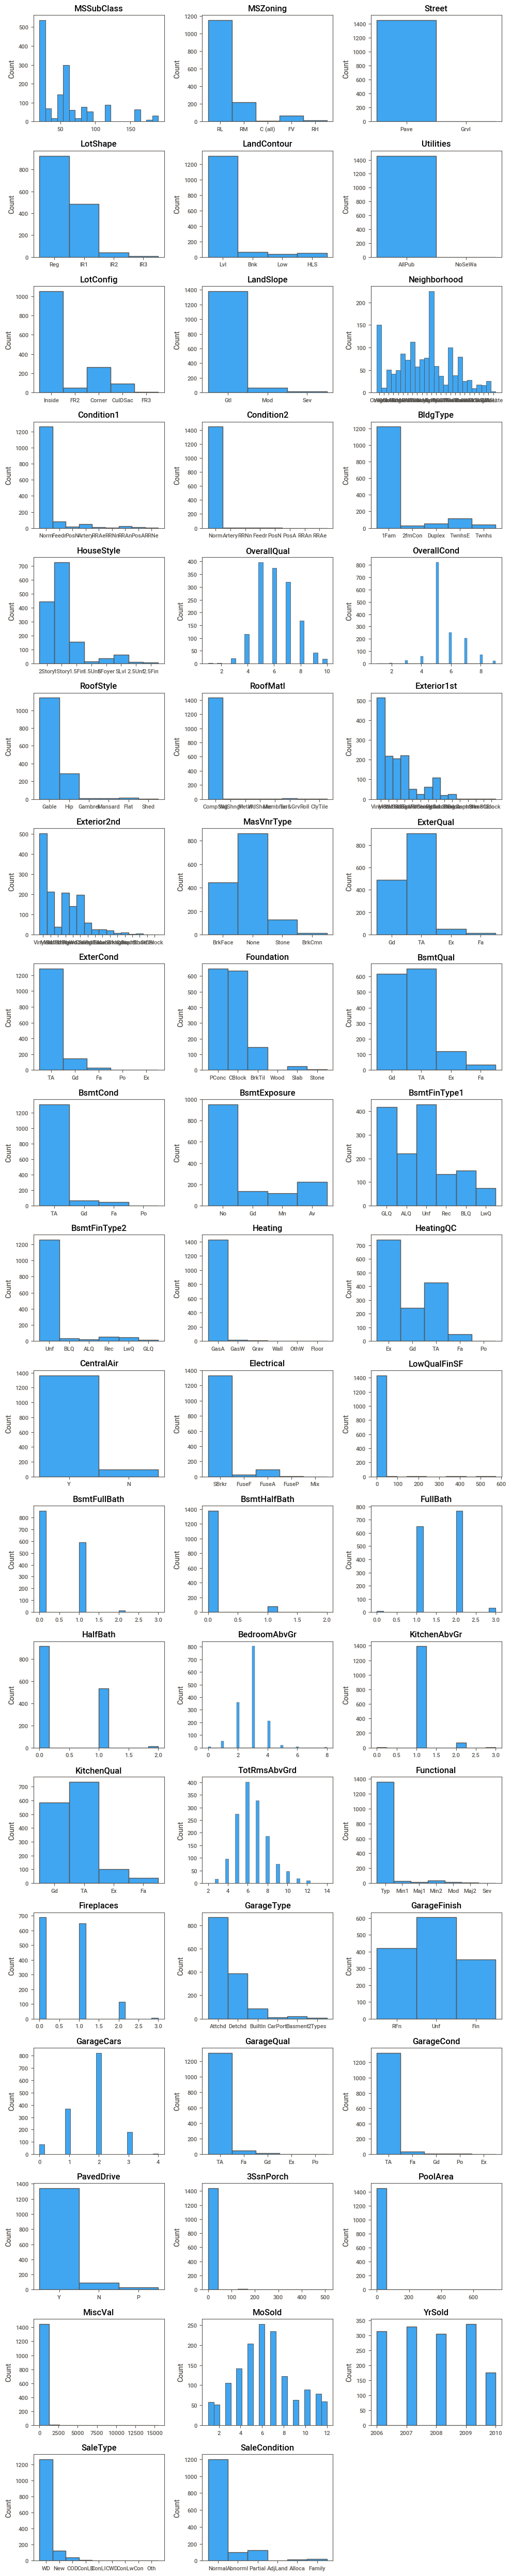

In [30]:
## Distributions of categorical features
fig = plt.figure(figsize=(10, 50))
for i, cf in enumerate(categorical_features):
    ax = fig.add_subplot(19, 3, i+1)
    sns.histplot(train[cf], kde=False, ax=ax)
    plt.title(cf)
    plt.xlabel(None)
fig.tight_layout()

#### Handling Null Values and Data Encoding

In [31]:
## Fill NaN in categorical columns with its mode
train[categorical_features] = train[categorical_features].fillna(train[categorical_features].mode().iloc[0])  
test[categorical_features] = test[categorical_features].fillna(train[categorical_features].mode().iloc[0])  

In [32]:
def df_encode(categorical_features,
              train_df,
              test_df,
              valid_df=None,
              encoding='one_hot',
              encoder=None,
              return_encoder=False):
    
    if encoder is not None:
        enc = encoder
    else:
        if encoding == 'one_hot':
            enc = preprocessing.OneHotEncoder(handle_unknown='ignore',
                                              sparse=False,
                                              dtype=np.int32)
            
        elif encoding == 'label':
            enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                               unknown_value=-1,
                                               dtype=np.int32)   
        #train = train_df.copy()
        #train_categorical = ohe.fit_transform(train[categorical_features])
        enc.fit(train_df[categorical_features])
        
    train_categorical = pd.DataFrame(enc.transform(train_df[categorical_features]),
                                     #columns=enc.get_feature_names_out(),
                                     columns=enc.get_feature_names(),
                                     )
    test_categorical = pd.DataFrame(enc.transform(test_df[categorical_features]),
                                    #columns=enc.get_feature_names_out(),
                                    columns=enc.get_feature_names(),
                                    )
    if valid_df is not None:
        valid_categorical = pd.DataFrame(enc.transform(valid_df[categorical_features]),
                                         #columns=enc.get_feature_names_out(),
                                         columns=enc.get_feature_names(),
                                         )
        if return_encoder:
            return train_categorical, valid_categorical, test_categorical, enc
        else:
            return train_categorical, valid_categorical, test_categorical
        
    if return_encoder:
        return train_categorical, test_categorical, enc
    else:
        return train_categorical, test_categorical

In [33]:
## One-Hot Encoding 
encoding = exp_config['encoding']

_, _, enc =  df_encode(categorical_features,
                       train,
                       test,
                       encoding=encoding,
                       return_encoder=True)
    
train_categorical, test_categorical = df_encode(categorical_features,
                                                train,
                                                test,
                                                encoding=encoding,
                                                encoder=enc)

print(train_categorical.shape, test_categorical.shape)

(1460, 405) (1459, 405)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



<a id ="3.6"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.6 Validation Split</center></h2>

In [34]:
## K-Fold validation split
n_splits = exp_config['n_splits']
kf = KFold(n_splits=n_splits)

train['k_folds'] = -1
train_target['k_folds'] = -1

for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    train['k_folds'][valid_idx] = fold
    train_target['k_folds'][valid_idx] = fold
    
for i in range(n_splits):
    print(f"fold {i}: {len(train.query('k_folds==@i'))} samples")

fold 0: 292 samples
fold 1: 292 samples
fold 2: 292 samples
fold 3: 292 samples
fold 4: 292 samples


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
## Hold-out validation split
valid_fold = train.query(f'k_folds == 0').reset_index(drop=True)
train_fold = train.query(f'k_folds != 0').reset_index(drop=True)

valid_fold_target = train_target.query(f'k_folds == 0').reset_index(drop=True)
train_fold_target = train_target.query(f'k_folds != 0').reset_index(drop=True)
print(len(train_fold), len(valid_fold))

1168 292


In [36]:
## Normalization of numerical features
normalization = exp_config['normalization']
train_numerical, valid_numerical, test_numerical = df_normalize(numerical_features,
                                                                train_fold,
                                                                test,
                                                                valid_df=valid_fold,
                                                                normalization=normalization)

## Encoding of categorical features
encoding = exp_config['encoding']
_, _, enc =  df_encode(categorical_features,
                       train,
                       test,
                       encoding=encoding,
                       return_encoder=True)

train_categorical, valid_categorical, test_categorical = df_encode(categorical_features,
                                                                   train_fold,
                                                                   test,
                                                                   valid_df=valid_fold,
                                                                   encoding=encoding,
                                                                   encoder=enc,
                                                                   return_encoder=False)

print(train_categorical.shape, test_categorical.shape)

(1168, 405) (1459, 405)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/s

<a id ="4"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>4. PyCaret</center></h1>

#### [PyCaret](https://pycaret.org/) is an open-source, low-code machine learning library in Python that automates machine learning workflows. 

Unfortunately, some PyCaret's codes doesn't work on Kaggle kernel when using GPU or TPU because of the differences between the library versions. Thus, I removed the cells operating PyCaret. If you are interested in AutoML or PyCaret, please check the previous version of this notebook (version 7 or more), and you can run them on CPU.

<a id ="5"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>5. Deep Learning</center></h1>

<a id ="5.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.1 Creating Dataset</center></h2>

---
## [TPU] Batch size ##

To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores). At this size, the 128x128 hardware matrix multipliers of the TPU (see hardware section below) are most likely to be kept busy. You start seeing interesting speedups from a batch size of 8 per core though. In the sample above, the batch size is scaled with the core count through this line of code:

In [37]:
if tpu:
    n_sample_per_TPU_core = exp_config['n_sample_per_TPU_core']
    batch_size = n_sample_per_TPU_core * strategy.num_replicas_in_sync
else:
    batch_size = exp_config['batch_size']

---

In [38]:
def df_to_dataset(numerical_dataframe, 
                  categorical_dataframe,
                  target_dataframe=None,
                  target_column='target_transformed',
                  shuffle=False, repeat=False,
                  batch_size=5, drop_remainder=False):
    
    numerical = numerical_dataframe.values
    categorical = categorical_dataframe.values
    features = np.concatenate([numerical, categorical], axis=1)
    
    if target_dataframe is not None:
        target = target_dataframe[target_column]
        ds = tf.data.Dataset.from_tensor_slices((features, target))
    else:
        ds = tf.data.Dataset.from_tensor_slices(features)
        
    if shuffle:
        ds = ds.shuffle(buffer_size=len(numerical))
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(batch_size)
    
    return ds

In [39]:
## Create datasets
batch_size = exp_config['batch_size']
target = 'target_transformed_standardized'

train_ds = df_to_dataset(train_numerical,
                         train_categorical,
                         target_dataframe=train_fold_target,
                         target_column=target,
                         shuffle=True,
                         repeat=False,
                         batch_size=batch_size,
                         drop_remainder=False,)
    
valid_ds = df_to_dataset(valid_numerical,
                         valid_categorical,
                         target_dataframe=valid_fold_target,
                         target_column=target,
                         shuffle=False,
                         repeat=False,
                         batch_size=batch_size,
                         drop_remainder=False,)

f, t = next(iter(train_ds))
print(f.shape, t.shape)

(128, 423) (128,)


2022-06-16 09:02:00.764768: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<a id ="5.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.2 Creating Model</center></h2>

In [40]:
def create_training_model(input_shape, model_units=[128,], dropout_rates=[0.2]):
    
    model_inputs = layers.Input(shape=input_shape)
    x = model_inputs
    
    for units, dropout_rate in zip(model_units, dropout_rates):
        feedforward = keras.Sequential([
            layers.Dense(units, use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(dropout_rate),
        ])
        x = feedforward(x)
        
    final_layer = layers.Dense(units=1, activation=None)
    model_outputs = final_layer(x)
    
    training_model = tf.keras.Model(inputs=model_inputs,
                                    outputs=model_outputs)
    return training_model

--- 
## [TPU] Model on TPUs ##

The strategy scope instructs Tensorflow to instantiate all the variables of the model in the memory of the TPU. The TPUClusterResolver.connect() call automatically enters the TPU device scope which instructs Tensorflow to run Tensorflow operations on the TPU. 

In [41]:
## Create training model
input_shape = (423, )
model_units = model_config['model_units']
dropout_rates = model_config['dropout_rates']

if tpu:
    with strategy.scope():
        training_model = create_training_model(input_shape=input_shape,
                                               model_units=model_units, 
                                               dropout_rates=dropout_rates)
else:
    training_model = create_training_model(input_shape=input_shape,
                                           model_units=model_units, 
                                           dropout_rates=dropout_rates)

## Model compile and build
lr = exp_config['learning_rate']
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = keras.losses.MeanSquaredError()

training_model.compile(optimizer=optimizer,
                       loss=loss_fn,
                       metrics=[keras.metrics.mean_squared_error,])

training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 423)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 256)               109312    
_________________________________________________________________
sequential_1 (Sequential)    (None, 256)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 176,129
Trainable params: 175,105
Non-trainable params: 1,024
_________________________________________________________________


---

<a id ="5.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.3 Training Model</center></h2>

---
## [TPU] Model saving/loading on TPUs ##
When loading and saving models TPU models from/to the local disk, the `experimental_io_device `option must be used. It can be omitted if writing to GCS because TPUs have direct access to GCS. This option does nothing on GPUs.

TPU users will remember that in order to train a model on TPU, you have to instantiate the model in a TPUStrategy scope. The strategy scope instructs Tensorflow to instantiate all the variables of the model in the memory of the TPU. The TPUClusterResolver.connect() call automatically enters the TPU device scope which instructs Tensorflow to run Tensorflow operations on the TPU. Now if you call model.save('./model') when you are connected to a TPU, Tensorflow will try to run the save operations on the TPU and since the TPU is a network-connected accelerator that has no access to your local disk, the operation will fail. Notice that saving to GCS will work though. The TPU does have access to GCS. If you want to save a TPU model to your local disk, you need to run the saving operation on your local machine and that is what the `experimental_io_device='/job:localhost'` flag does.

In [42]:
## Settings for Training
epochs = exp_config['train_epochs']
batch_size = exp_config['batch_size']
steps_per_epoch = len(train_fold)//batch_size 

## For saving the best model
checkpoint_filepath = exp_config['checkpoint_filepath']
if tpu:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=False, 
        monitor='val_loss', 
        mode='min', 
        save_best_only=True,
        options=save_locally)
else:
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True, 
        monitor='val_loss', 
        mode='min', 
        save_best_only=True)

## For the adjustment of learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    cooldown=10,
    min_lr=1e-5,
    verbose=1)

## Model training
history = training_model.fit(train_ds,
                             epochs=epochs,
                             shuffle=True,
                             validation_data=valid_ds,
                             callbacks=[model_checkpoint_callback,
                                        reduce_lr,
                                        ]
                             )

## Load the best parameters
if tpu:
    with strategy.scope():
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        training_model = tf.keras.models.load_model(checkpoint_filepath,
                                                    options=load_locally)
else:
    training_model.load_weights(checkpoint_filepath)

Epoch 1/100


2022-06-16 09:02:07.514185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10/10 [==============================] - 1s 28ms/step - loss: 0.9616 - mean_squared_error: 0.9616 - val_loss: 0.6402 - val_mean_squared_error: 0.6402
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5502 - mean_squared_error: 0.5502 - val_loss: 0.5059 - val_mean_squared_error: 0.5059
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4006 - mean_squared_error: 0.4006 - val_loss: 0.4299 - val_mean_squared_error: 0.4299
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.3518 - mean_squared_error: 0.3518 - val_loss: 0.5074 - val_mean_squared_error: 0.5074
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2818 - mean_squared_error: 0.2818 - val_loss: 0.4636 - val_mean_squared_error: 0.4636
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.4019 - val_mean_squared_error: 0.4019
Epoch 7/100
10/10 [==========================

---

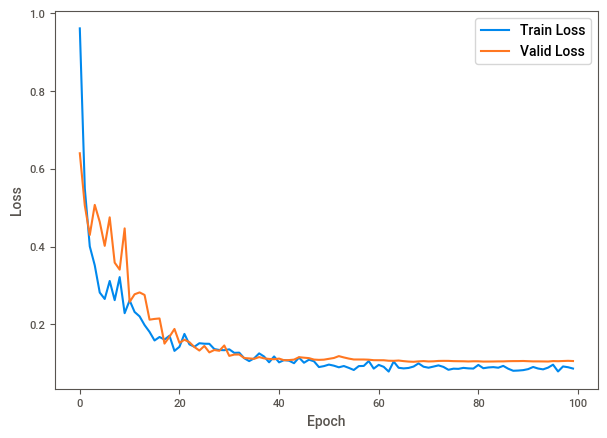

In [43]:
## Plot the train and valid losses
def plot_history(hist, title=None, valid=True):
    plt.figure(figsize=(7, 5))
    plt.plot(np.array(hist.index), hist['loss'], label='Train Loss')
    if valid:
        plt.plot(np.array(hist.index), hist['val_loss'], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()
    
hist = pd.DataFrame(history.history)
plot_history(hist)

<a id ="5.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>5.4 Inference</center></h2>

In [44]:
## Create test dataset
test_ds = df_to_dataset(test_numerical,
                        test_categorical,
                        target_dataframe=None,
                        shuffle=False,
                        repeat=False,
                        batch_size=batch_size,
                        drop_remainder=False,)

f= next(iter(test_ds))
print(f.shape)

(128, 423)


In [45]:
preds = training_model.predict(test_ds)
preds = np.squeeze(preds)

def reverse_transformation(preds,
                           mean=box_cox_mean,
                           std=box_cox_std,
                           box_cox_lambda=best_lambda):
    x = (preds * std) + mean
    x = sp.special.inv_boxcox(x, box_cox_lambda)
    return x 

price_inference = reverse_transformation(preds)
submission_df['SalePrice'] = price_inference
submission_df.to_csv('submission_dnn.csv', index=False)
submission_df.head()

Id      SalePrice
0  1461  128933.195312
1  1462  155587.828125
2  1463  179008.234375
3  1464  203923.093750
4  1465  177125.656250